## Agroforestry Suitability Workflow


1. **Start from a plot**  
   - Define the plot location and record the current agroforestry system (species, density, shading, yield).

2. **Gather species occurrence data**  
   - Search GBIF and/or local datasets for occurrences in a **wider training region**.  
   - Clean, filter, and spatially thin to reduce bias.  
   - Optionally remove isolated or wild points if focusing on cultivated systems.

3. **Prepare environmental predictors**  
   - Load current climate data (e.g., TerraClimate).  

4. **Generate background (absence) points**  
   - Sample across the training region, restricted to land.  
   - Ensure coverage across environmental gradients (e.g., lowlands, highlands).

5. **Train the species distribution model (SDM)**  
   - Use a Random Forest classifier with presence/absence data.  
   - Evaluate performance (AUC, sensitivity, specificity).  
   - Determine a probability threshold for suitability.

6. **Predict suitability**  
   - For **current** climate conditions.  
   - For **future** climate scenarios.


---

**Goal:**  
Provide decision‑makers with:
- **Regional context** to understand how local changes fit into broader production trends.


In [1]:
from pathlib import Path
import sys

this_dir = Path().resolve()        # current working directory
parent_dir = this_dir.parent
sys.path.insert(0, str(parent_dir))




In [2]:
import pandas as pd
from config import DATA_DIR

# Path to your cleaned observation file
obs_path = DATA_DIR / "species_location/species_occurrences_combined_cleaned.csv"

# Read file
df_obs = pd.read_csv(obs_path)

# Normalise column names
rename_map = {
    "species": "species_query", "scientificName": "species_query",
    "Longitude": "decimalLongitude", "lon": "decimalLongitude", "lng": "decimalLongitude",
    "Latitude": "decimalLatitude",   "lat": "decimalLatitude",
}
for k, v in rename_map.items():
    if k in df_obs.columns and v not in df_obs.columns:
        df_obs = df_obs.rename(columns={k: v})

# Drop rows with no species info
df_obs = df_obs.dropna(subset=["species_query"])

# Get unique species
unique_species = sorted(df_obs["species_query"].unique())

# Show as list
for sp in unique_species:
    print(sp)

print(f"\nTotal unique species: {len(unique_species)}")


Annona muricata
Artocarpus altilis
Byrsonima crassifolia
Cajanus cajan
Carica papaya
Cedrela odorata
Citrus aurantium
Citrus sinensis
Coffea arabica
Cordia alliodora
Erythrina poeppigiana
Gliricidia sepium
Inga edulis
Inga jinicuil
Inga vera
Macadamia integrifolia
Mangifera indica
Musa paradisiaca
Persea americana
Pouteria sapota
Psidium guajava
Spondias mombin
Swietenia macrophylla
Theobroma cacao

Total unique species: 24


### Cleaning species occurrence data

The function `clean_occurrences` helps prepare occurrence points for analysis by:

1. **Removing isolated points**  
   - Discards records that are farther than a set distance (`max_isolate_distance_deg`, default 0.5°) from all other points.  
   - Helps eliminate outliers or imprecise records.

2. **Applying spatial thinning**  
   - Splits the study area into grid cells of size `thinning_deg` (default ≈ 2.5 arc-min ≈ 0.0417°).  
   - Keeps only **one random record per grid cell** to avoid clustering bias.

3. **Outputs**  
   - Returns a cleaned `DataFrame` with fewer, more evenly distributed points.  
   - Prints a per-species summary of records before and after cleaning.


In [3]:
import numpy as np
import pandas as pd
from utils_suitability_modelling import *

df = clean_occurrences(
    df_obs,
    max_isolate_distance_deg=0.1,   # ~11 km
    thinning_deg=2.5/60             # 2.5 arc-min (~4.6 km)
)

print(f"✅ Cleaned dataset: {len(df)} records")


Annona muricata: 914 → 457 after cleaning
Artocarpus altilis: 1108 → 558 after cleaning
Byrsonima crassifolia: 2330 → 1340 after cleaning
Cajanus cajan: 469 → 255 after cleaning
Carica papaya: 2610 → 1399 after cleaning
Cedrela odorata: 1408 → 772 after cleaning
Citrus aurantium: 256 → 103 after cleaning
Citrus sinensis: 362 → 146 after cleaning
Coffea arabica: 3561 → 1725 after cleaning
Cordia alliodora: 1272 → 615 after cleaning
Erythrina poeppigiana: 133 → 60 after cleaning
Gliricidia sepium: 1914 → 1027 after cleaning
Inga edulis: 1570 → 866 after cleaning
Inga jinicuil: 194 → 88 after cleaning
Inga vera: 1989 → 1155 after cleaning
Macadamia integrifolia: 10 → 1 after cleaning
Mangifera indica: 2018 → 1068 after cleaning
Musa paradisiaca: 487 → 224 after cleaning
Persea americana: 1878 → 1072 after cleaning
Pouteria sapota: 476 → 225 after cleaning
Psidium guajava: 3034 → 1693 after cleaning
Spondias mombin: 820 → 373 after cleaning
Swietenia macrophylla: 550 → 230 after cleaning
T

In [4]:
occ_all = df.rename(columns={"species_query":"species",
    "decimalLongitude": "lon",
    "decimalLatitude": "lat",
})[["species", "lon", "lat"]].dropna()
occ_all

,species,lon,lat
0,Annona muricata,-106.682167,24.415475
1,Annona muricata,-106.423805,23.193857
2,Annona muricata,-106.429925,23.232595
3,Annona muricata,-106.423988,23.260112
4,Annona muricata,-106.443430,23.299000
...,...,...,...
15948,Theobroma cacao,-60.906423,14.601630
15949,Theobroma cacao,-60.859124,14.513195
15950,Theobroma cacao,-60.585957,11.254710
15951,Theobroma cacao,-60.549420,11.316900


In the following cell, we force some observation points from the agrosystems that we generated. As we need to make sure that those are suitable today. We had the issue previously that some areas were not suitable, altough they should be because we did not have observations.
those would ideally correspond to true observations.

In [5]:
import pandas as pd
import numpy as np
import requests
from pathlib import Path

# ====================================================
# Helper: get elevation via Open-Elevation API
# ====================================================
def get_elevation(lat: float, lon: float) -> float:
    """Query Open-Elevation API for elevation in meters."""
    try:
        url = "https://api.open-elevation.com/api/v1/lookup"
        r = requests.get(url, params={"locations": f"{lat},{lon}"}, timeout=10)
        if r.ok:
            return float(r.json()["results"][0]["elevation"])
    except Exception:
        pass
    return None

# ====================================================
# Jiggle generator (system-level)
# ====================================================
def generate_jiggle_points_system(base_point, n_per_point=5, jitter_deg=0.1):
    """Generate jiggle points around a system centroid."""
    jiggle_list = []
    for _ in range(n_per_point):
        lon_j = base_point["lon"] + np.random.uniform(-jitter_deg, jitter_deg)
        lat_j = base_point["lat"] + np.random.uniform(-jitter_deg, jitter_deg)
        jiggle_list.append({"lon": lon_j, "lat": lat_j, "source": "jiggle"})
    return pd.DataFrame(jiggle_list)

# ====================================================
# Collect systems (Excel files)
# ====================================================
data_dir = Path("../agroforestry_systems")
excel_files = sorted(data_dir.glob("*.xlsx"))

all_points = []

for file_path in excel_files:
    try:
        df = pd.read_excel(file_path, sheet_name="present")
    except ValueError:
        continue

    # Standardise species names
    sp_col = "Scientific name" if "Scientific name" in df.columns else "Species"

    # Base coordinates: take the centroid of provided points in this system
    if {"Longitude", "Latitude"}.issubset(df.columns):
        lon0 = df["Longitude"].mean()
        lat0 = df["Latitude"].mean()
    else:
        continue

    # Generate jiggles at system level
    jiggles = generate_jiggle_points_system({"lon": lon0, "lat": lat0}, n_per_point=5)

    # Add the centroid as well
    jiggles = pd.concat([pd.DataFrame([{"lon": lon0, "lat": lat0, "source": "excel"}]), jiggles], ignore_index=True)

    # Query elevation ONCE per jiggle
    jiggles["elevation"] = jiggles.apply(lambda r: get_elevation(r.lat, r.lon), axis=1)

    # Assign all jiggle points to all species in this system
    for sp in df[sp_col].dropna().unique():
        tmp = jiggles.copy()
        tmp["species"] = sp
        tmp["system"] = file_path.stem
        all_points.append(tmp)

# ====================================================
# Apply species-specific elevation filters
# ====================================================
def valid_elevation(row):
    if row["species"] == "Coffea arabica":
        return 600 <= row["elevation"] <= 2000
    elif row["species"] == "Theobroma cacao":
        return 120 <= row["elevation"] <= 800
    else:  # other species: keep within the broadest band
        return 120 <= row["elevation"] <= 2000

# --- Merge all jiggle/system points ---
system_points = pd.concat(all_points, ignore_index=True)

# --- Apply elevation filters ONLY to jiggle/system points ---
system_points = system_points[
    system_points["elevation"].notna() & system_points.apply(valid_elevation, axis=1)
]

# --- Concatenate with your original GBIF observations ---
occ_all = pd.concat([occ_all, system_points], ignore_index=True)


### Building the training dataset for suitability modelling

In this step, we prepare the **input dataset** that will be used to train the suitability model for each target species.

**Workflow:**

1. **Load climate predictors**
   - Open the `bio_stack` from TerraClimate (1990–2014 baseline).
   - This contains gridded bioclimatic variables such as temperature, precipitation, PET, AET, and solar radiation.
   - The file is an `xarray.Dataset`, which allows fast spatial extraction.

2. **Define modelling extent**
   - Specify the bounding box (`bbox`) for the study region.
   - This ensures we only extract presence and background points from within the relevant spatial domain.

3. **Select predictors**
   - Choose which climate variables to use for model training.
   - Selected variables can be adjusted depending on the research question and collinearity checks.

4. **Build the training dataset**  
   - Call `build_training_dataset()`:
     - Filters the presence dataset (`occ_all`) to the study area.
     - Generates background (pseudo‑absence) points within the study area.
     - Extracts climate predictor values for all points from `bio_stack`.
     - Combines presence (label = 1) and background (label = 0) into a single DataFrame.

5. **Result**
   - The resulting `data_all` contains:
     - Geographic coordinates.
     - Selected climate predictor values.
     - Presence/absence labels.
     - Species identifiers.
   - This is the core dataset for training species distribution models.

**Notes:**
- The `background_ratio` parameter controls how many background points are generated relative to the number of presences (here: 3×).
- This step **does not yet fit the model** — it only prepares the inputs.
- The presence dataset (`occ_all`) should be cleaned before this step (e.g., remove duplicates, isolates, and apply spatial thinning if needed).


In [6]:
from utils_suitability_modelling import build_training_dataset

import xarray as xr

# 📂 Path to your climate predictor stack
bio_path = DATA_DIR / "terra_climate/SuitabilityVariables_1990_2014.nc"

# 1️⃣ Open dataset
bio_stack = xr.open_dataset(bio_path)




# 📋 Inputs
bbox = (-115, -50, 10, 25)  # adjust to your study area

selected_predictors = [
    "MeanDiurnalRange",
    "Isothermality",
    "PrecSeasonality",
    "AnnualPET",
    "MeanTempDriestQuarter",
    "PrecDriestMonth",
    "PrecWettestMonth",
    "AnnualAET",
    "AnnualDeficit",
    "MeanSRAD",
    "MeanTempWettestQuarter",
    "PrecWarmestQuarter",
    "PrecColdestQuarter",
]
#bio_stack = bio_stack.rename({"lon": "y", "lat": "x"})

# 📂 Run
data_all = build_training_dataset(
    presence_df=occ_all,       # df with ['species', 'lon', 'lat']
    bio_stack=bio_stack,       # xarray.Dataset of your climate variables
    bbox=bbox,
    selected_predictors=selected_predictors,
    background_ratio=3
)

data_all.head()


✅ Found 16176 presence points in study area.


/Users/szelie/python_projects/biofincas_climate_risk/agroforest_risk/utils_suitability_modelling.py:77: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  land = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


🚀 Querying predictors for 40453 points…
🎉 Final dataset: 21094 records.
presence
1    16094
0     5000
Name: count, dtype: int64
species
background                5000
Coffea arabica            1737
Psidium guajava           1682
Carica papaya             1388
Byrsonima crassifolia     1339
Inga vera                 1160
Persea americana          1100
Mangifera indica          1069
Gliricidia sepium         1035
Inga edulis                866
Cedrela odorata            767
Cordia alliodora           621
Artocarpus altilis         562
Theobroma cacao            508
Annona muricata            455
Spondias mombin            378
Cajanus cajan              254
Pouteria sapota            241
Swietenia macrophylla      234
Musa paradisiaca           228
Citrus sinensis            162
Citrus aurantium           113
Inga jinicuil               88
Erythrina poeppigiana       60
Inga spp.                   10
Protium copal                6
Inga sapindoides             6
Quercus sapotifolia       

,MeanDiurnalRange,Isothermality,PrecSeasonality,AnnualPET,MeanTempDriestQuarter,PrecDriestMonth,PrecWettestMonth,AnnualAET,AnnualDeficit,MeanSRAD,MeanTempWettestQuarter,PrecWarmestQuarter,PrecColdestQuarter,lon,lat,presence,species
0,14.358133,59.493384,116.494341,1556.236,23.819067,0.592,298.744,852.916,703.320,207.840000,27.470533,455.520,58.476,-106.682167,24.415475,1,Annona muricata
1,9.263100,51.614215,132.873966,1550.084,22.590733,0.000,296.036,769.496,780.588,211.907333,29.022467,564.056,24.336,-106.423805,23.193857,1,Annona muricata
2,9.507167,52.329187,132.011151,1580.628,22.887733,0.168,291.924,766.388,814.240,211.205667,29.344000,553.904,24.556,-106.429925,23.232595,1,Annona muricata
3,9.812033,53.304251,130.981796,1570.816,22.916800,0.168,285.504,756.404,814.412,208.967333,29.335133,541.484,24.608,-106.423988,23.260112,1,Annona muricata
4,10.136067,55.078937,130.956449,1572.300,23.064933,0.172,282.452,748.688,823.612,210.115333,29.106733,522.076,27.920,-106.443430,23.299000,1,Annona muricata


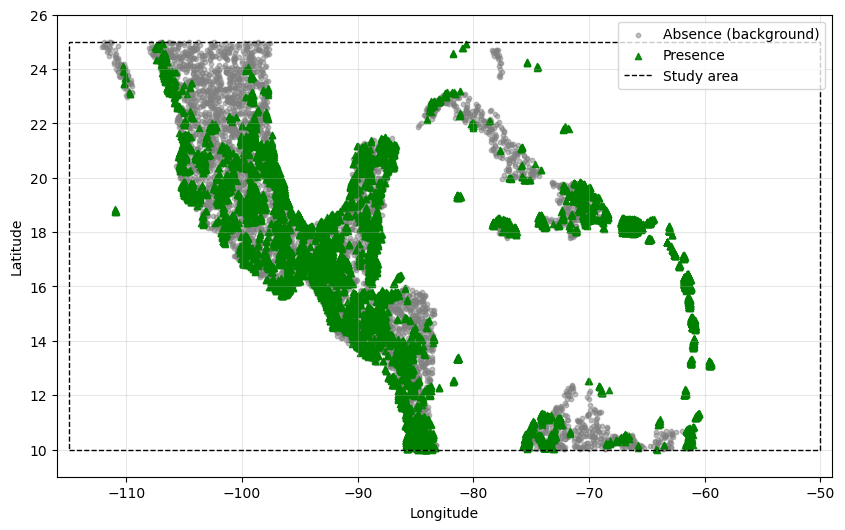

In [7]:
import matplotlib.pyplot as plt


lon_min, lon_max, lat_min, lat_max = bbox

# 📋 Separate presence & absence
presences = data_all[data_all["presence"] == 1]
absences  = data_all[data_all["presence"] == 0]

plt.figure(figsize=(10, 6))

# Background points (absence)
plt.scatter(
    absences["lon"], absences["lat"],
    color="grey", alpha=0.5, s=10, label="Absence (background)"
)

# Presence points
plt.scatter(
    presences["lon"], presences["lat"],
    color="green", alpha=0.9, s=20, marker='^', label="Presence"
)

# Study area bbox
plt.plot(
    [lon_min, lon_max, lon_max, lon_min, lon_min],
    [lat_min, lat_min, lat_max, lat_max, lat_min],
    color="black", linestyle="--", linewidth=1, label="Study area"
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.xlim(lon_min - 1, lon_max + 1)
plt.ylim(lat_min - 1, lat_max + 1)
plt.grid(True, alpha=0.3)
plt.show()


/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_26403/2111968179.py:20: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


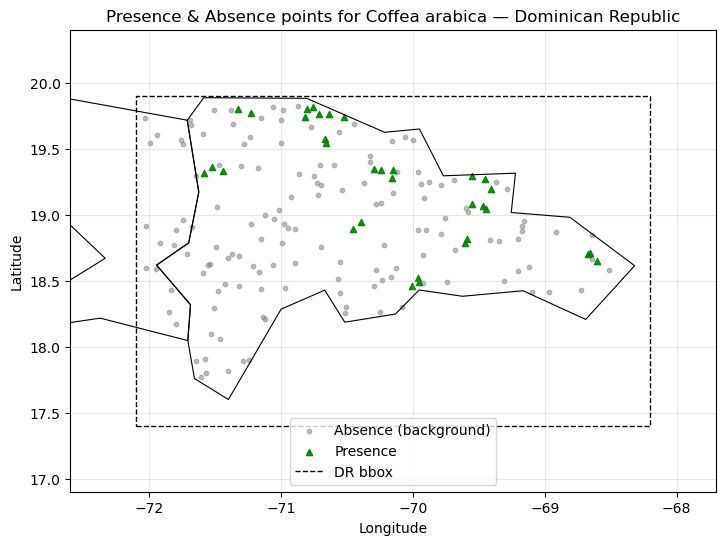

In [8]:
import matplotlib.pyplot as plt
import geopandas as gpd

# --- Dominican Republic bounding box ---
dr_bbox = (-72.1, -68.2, 17.4, 19.9)  # (min_lon, max_lon, min_lat, max_lat)
lon_min, lon_max, lat_min, lat_max = dr_bbox

# --- Filter for coffee presences and background absences in DR ---
dr_points = data_all[
    ((data_all["species"] == "Theobroma cacao") | (data_all["species"] == "background")) &
    (data_all["lon"] >= lon_min) & (data_all["lon"] <= lon_max) &
    (data_all["lat"] >= lat_min) & (data_all["lat"] <= lat_max)
]

# --- Separate presence & absence ---
presences = dr_points[dr_points["presence"] == 1]
absences  = dr_points[dr_points["presence"] == 0]

# --- Load world borders ---
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6))

# Country borders
world.boundary.plot(ax=ax, color="black", linewidth=0.8)

# Absence points
ax.scatter(
    absences["lon"], absences["lat"],
    color="grey", alpha=0.5, s=10, label="Absence (background)"
)

# Presence points
ax.scatter(
    presences["lon"], presences["lat"],
    color="green", alpha=0.9, s=20, marker='^', label="Presence"
)

# DR bbox outline
ax.plot(
    [lon_min, lon_max, lon_max, lon_min, lon_min],
    [lat_min, lat_min, lat_max, lat_max, lat_min],
    color="black", linestyle="--", linewidth=1, label="DR bbox"
)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Presence & Absence points for Coffea arabica — Dominican Republic")
ax.legend()
ax.set_xlim(lon_min - 0.5, lon_max + 0.5)
ax.set_ylim(lat_min - 0.5, lat_max + 0.5)
ax.grid(True, alpha=0.3)

plt.show()


## --> our points are quite sparce for the DR, we would need more observations ideally

## Species Suitability Modelling with Random Forest

The following cell trains **Random Forest** models to predict habitat suitability for multiple species based on environmental predictors.  
It uses **presence/background points**, applies filtering to remove correlated and redundant predictors, and evaluates model performance.

### Workflow
1. **Input Data**
   - `data_all` must contain:
     - `species` — species name
     - `presence` — binary presence/background label (`1` = presence, `0` = background)
     - `lon`, `lat` — coordinates in decimal degrees
     - Environmental predictors matching `selected_predictors`

2. **Settings**
   - `species_to_plot` — species for which to plot feature importance
   - `min_distance_deg` — minimum distance between presence and background points
   - `corr_threshold` — maximum Pearson correlation allowed
   - `vif_threshold` — maximum Variance Inflation Factor allowed
   - `n_estimators` — number of trees in the Random Forest
   - `min_importance` — minimum RF importance to retain predictors

3. **Feature Selection**
   - **Correlation filter**: remove highly correlated predictors
   - **VIF filter**: remove predictors with high multicollinearity
   - **Low-importance filter**: remove features with low RF importance

4. **Model Training**
   - Filter background points to be at least `min_distance_deg` from presence points
   - Split into train/test sets (70/30, stratified)
   - Train Random Forest
   - Retrain after removing low-importance predictors

5. **Evaluation**
   - Compute **AUC** (Area Under ROC Curve)
   - Determine optimal threshold for **max sensitivity + specificity**
   - Plot feature importance for selected species

6. **Outputs**
   - AUC scores per species
   - Feature importance plots
   - Suitability predictions for each point
   - Dictionaries of:
     - `trained_classifiers`
     - `feature_columns` used per species
     - `results_by_species`
   - `df_all_results` with predictions for all species


📉 Dropped correlated predictors: ['AnnualDeficit', 'MeanTempWettestQuarter']
🌳 AUC (holdout): 0.977
🎯 Threshold (max sens+spec): 0.13
🔁 Cross-val AUC: 0.961 ± 0.017


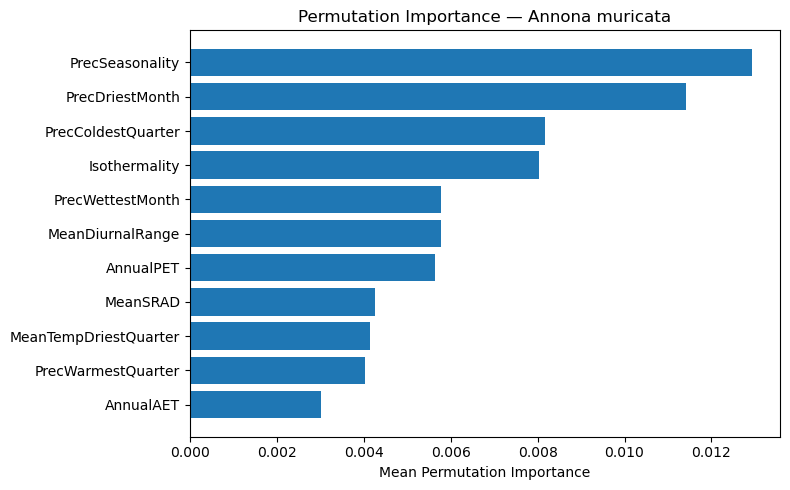

📉 Dropped correlated predictors: ['AnnualDeficit', 'MeanTempWettestQuarter']
🌳 AUC (holdout): 0.986
🎯 Threshold (max sens+spec): 0.10
🔁 Cross-val AUC: 0.991 ± 0.006


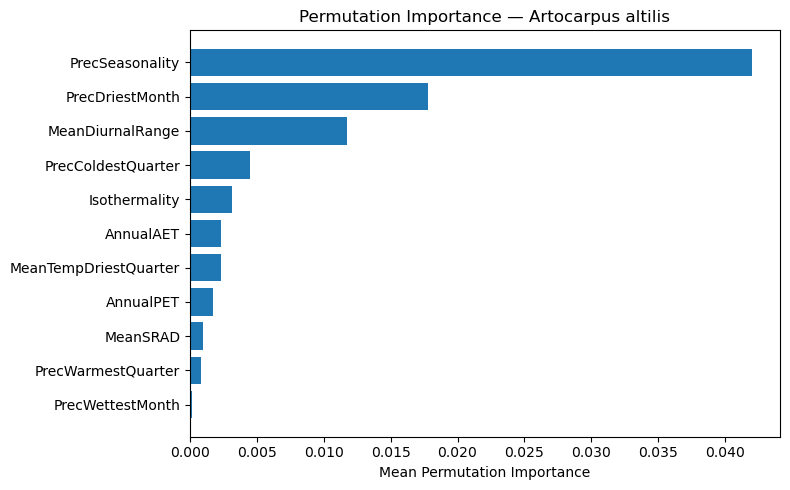

📉 Dropped correlated predictors: ['AnnualDeficit', 'MeanTempWettestQuarter']
🌳 AUC (holdout): 0.946
🎯 Threshold (max sens+spec): 0.28
🔁 Cross-val AUC: 0.947 ± 0.006


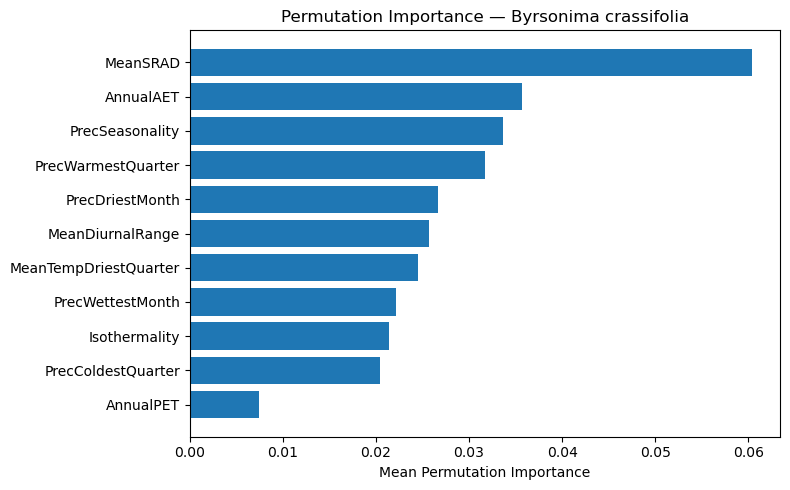

📉 Dropped correlated predictors: ['AnnualDeficit', 'MeanTempWettestQuarter']
🌳 AUC (holdout): 0.983
🎯 Threshold (max sens+spec): 0.09
🔁 Cross-val AUC: 0.981 ± 0.011


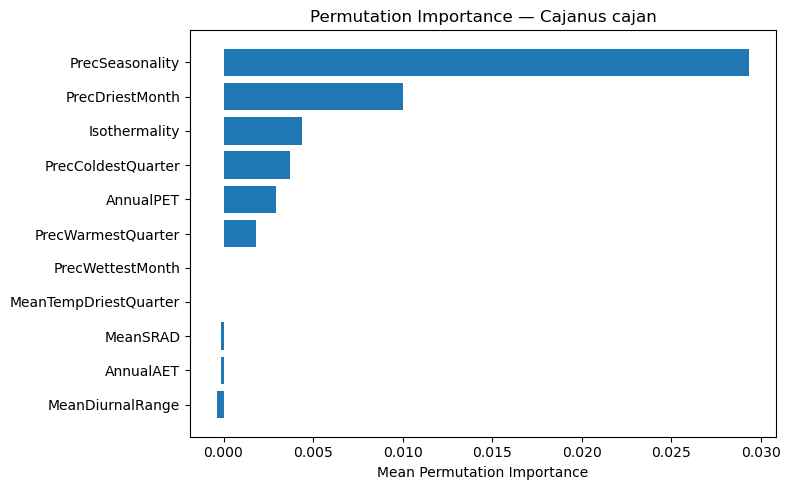

📉 Dropped correlated predictors: ['AnnualDeficit', 'MeanTempWettestQuarter']
🌳 AUC (holdout): 0.960
🎯 Threshold (max sens+spec): 0.33
🔁 Cross-val AUC: 0.959 ± 0.009


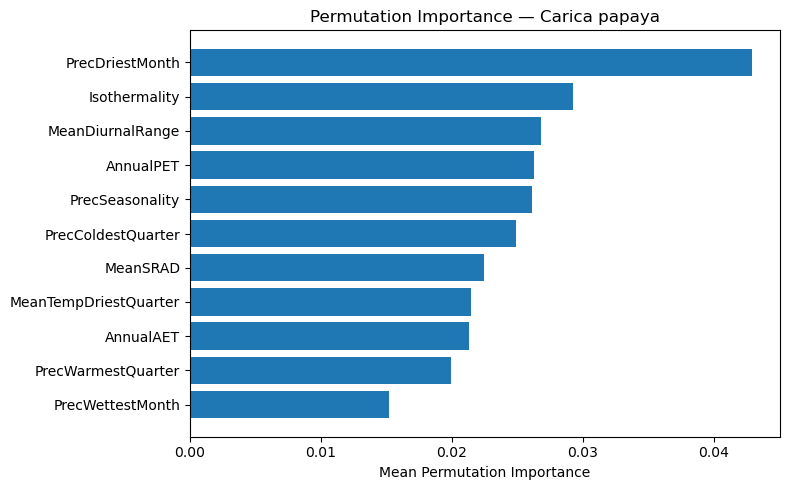

📉 Dropped correlated predictors: ['AnnualDeficit', 'MeanTempWettestQuarter']
🌳 AUC (holdout): 0.925
🎯 Threshold (max sens+spec): 0.15
🔁 Cross-val AUC: 0.936 ± 0.011


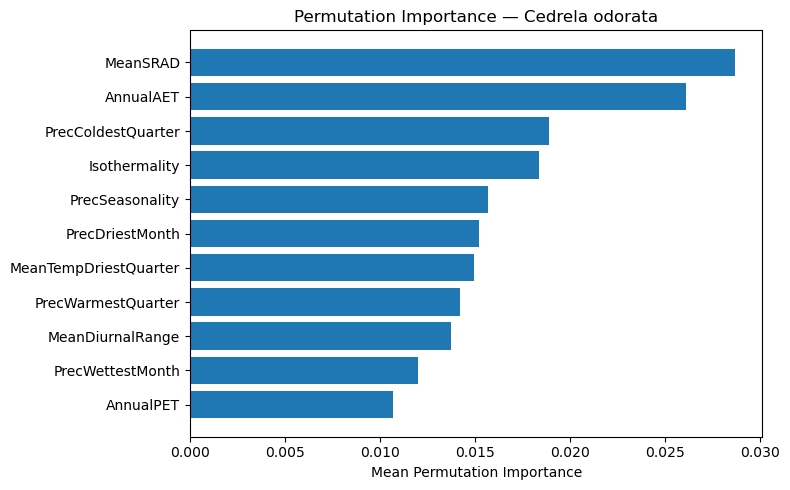

📉 Dropped correlated predictors: ['AnnualDeficit', 'MeanTempWettestQuarter']
🌳 AUC (holdout): 0.948
🎯 Threshold (max sens+spec): 0.06
🔁 Cross-val AUC: 0.965 ± 0.011


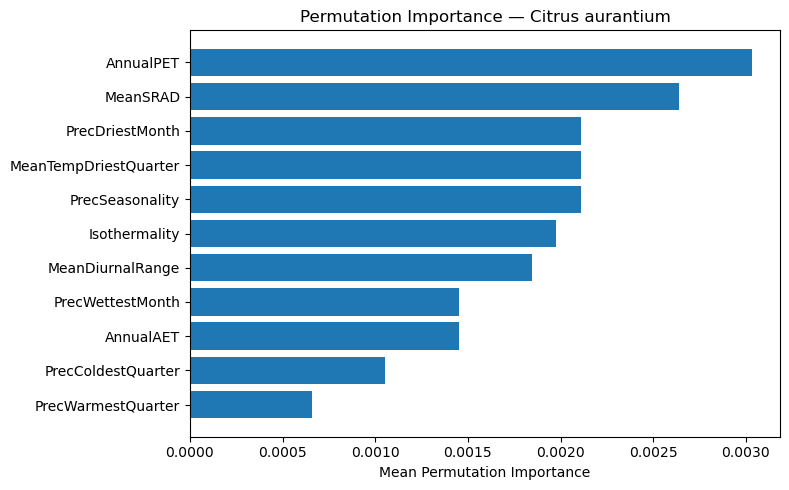

📉 Dropped correlated predictors: ['AnnualDeficit', 'MeanTempWettestQuarter']
🌳 AUC (holdout): 0.961
🎯 Threshold (max sens+spec): 0.08
🔁 Cross-val AUC: 0.950 ± 0.007


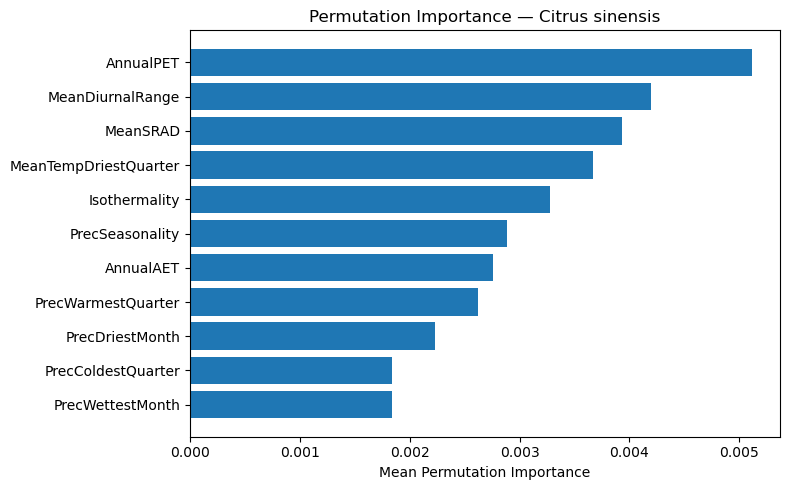

📉 Dropped correlated predictors: ['AnnualDeficit', 'MeanTempWettestQuarter']
🌳 AUC (holdout): 0.984
🎯 Threshold (max sens+spec): 0.28
🔁 Cross-val AUC: 0.982 ± 0.006


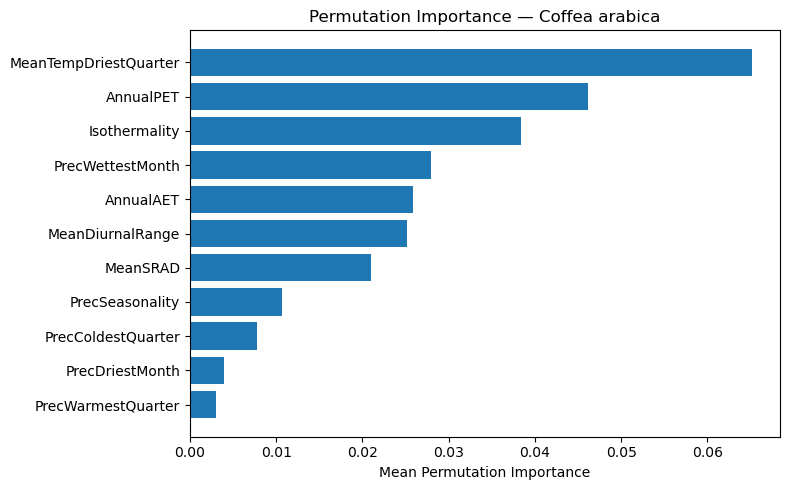

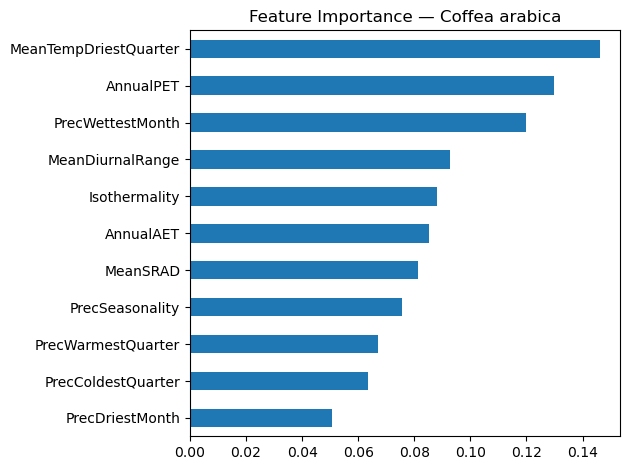

📉 Dropped correlated predictors: ['AnnualDeficit', 'MeanTempWettestQuarter']
🌳 AUC (holdout): 0.950
🎯 Threshold (max sens+spec): 0.25
🔁 Cross-val AUC: 0.958 ± 0.007


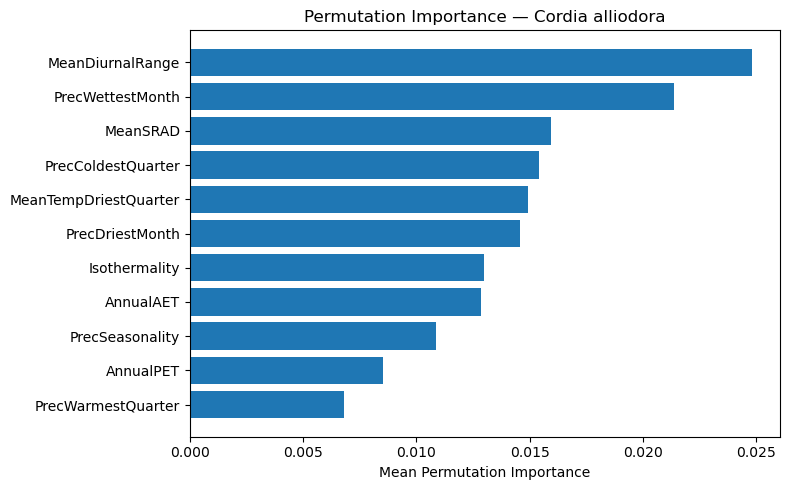

📉 Dropped correlated predictors: ['AnnualDeficit', 'MeanTempWettestQuarter']
🌳 AUC (holdout): 0.994
🎯 Threshold (max sens+spec): 0.03
🔁 Cross-val AUC: 0.983 ± 0.009


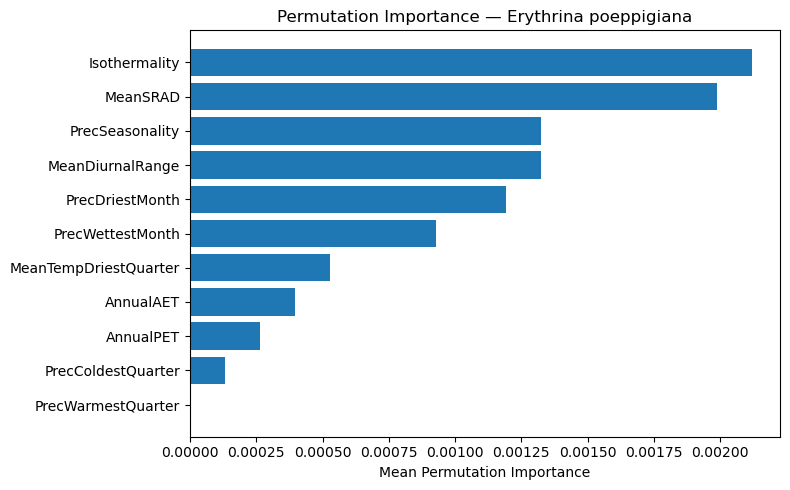

📉 Dropped correlated predictors: ['AnnualDeficit', 'MeanTempWettestQuarter']
🌳 AUC (holdout): 0.947
🎯 Threshold (max sens+spec): 0.19
🔁 Cross-val AUC: 0.954 ± 0.006


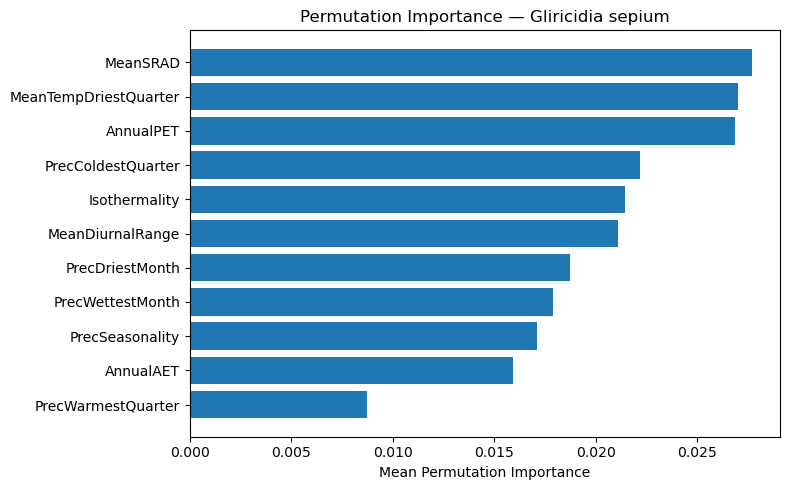

📉 Dropped correlated predictors: ['AnnualDeficit', 'MeanTempWettestQuarter']
🌳 AUC (holdout): 0.943
🎯 Threshold (max sens+spec): 0.20
🔁 Cross-val AUC: 0.952 ± 0.006


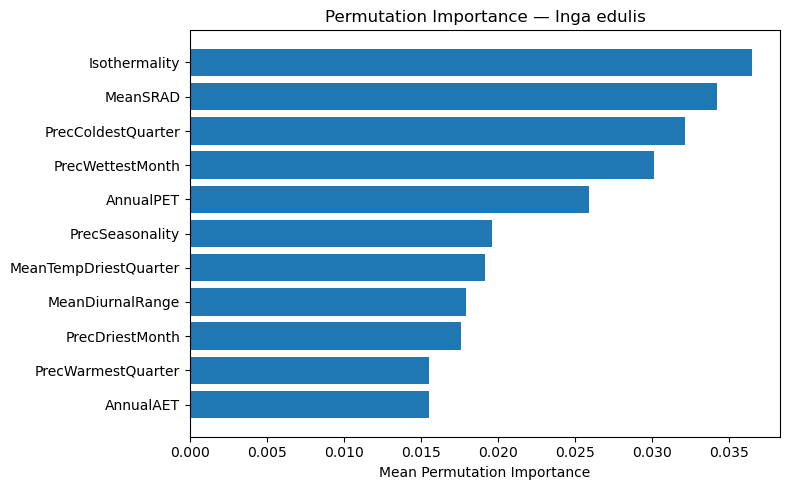

📉 Dropped correlated predictors: ['AnnualDeficit', 'MeanTempWettestQuarter']
🌳 AUC (holdout): 0.991
🎯 Threshold (max sens+spec): 0.06
🔁 Cross-val AUC: 0.972 ± 0.026


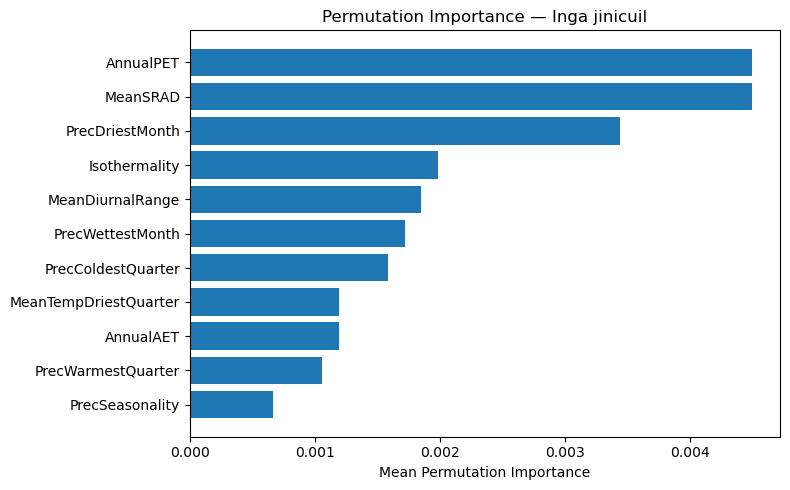

📉 Dropped correlated predictors: ['AnnualDeficit', 'MeanTempWettestQuarter']
🌳 AUC (holdout): 0.946
🎯 Threshold (max sens+spec): 0.32
🔁 Cross-val AUC: 0.954 ± 0.005


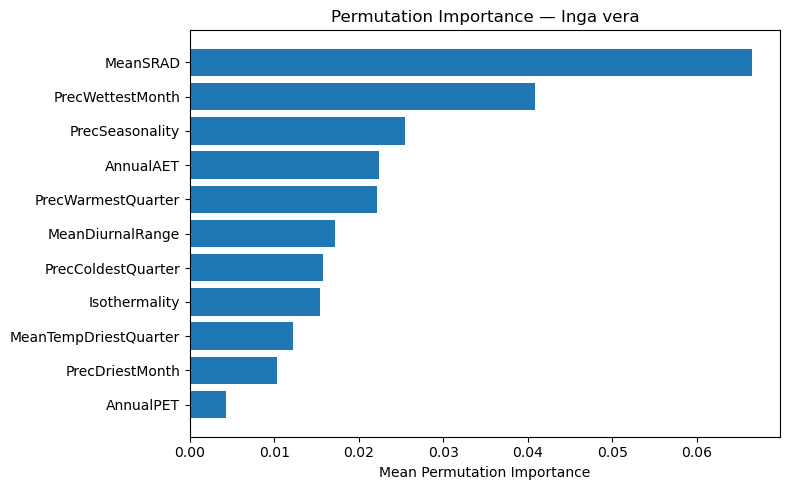

📉 Dropped correlated predictors: ['AnnualDeficit', 'MeanTempWettestQuarter']
🌳 AUC (holdout): 0.946
🎯 Threshold (max sens+spec): 0.20
🔁 Cross-val AUC: 0.963 ± 0.006


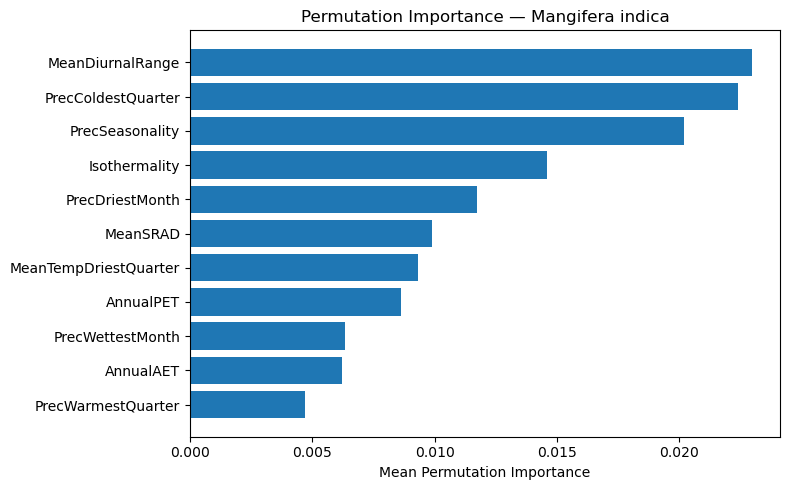

📉 Dropped correlated predictors: ['AnnualDeficit', 'MeanTempWettestQuarter']
🌳 AUC (holdout): 0.963
🎯 Threshold (max sens+spec): 0.06
🔁 Cross-val AUC: 0.943 ± 0.029


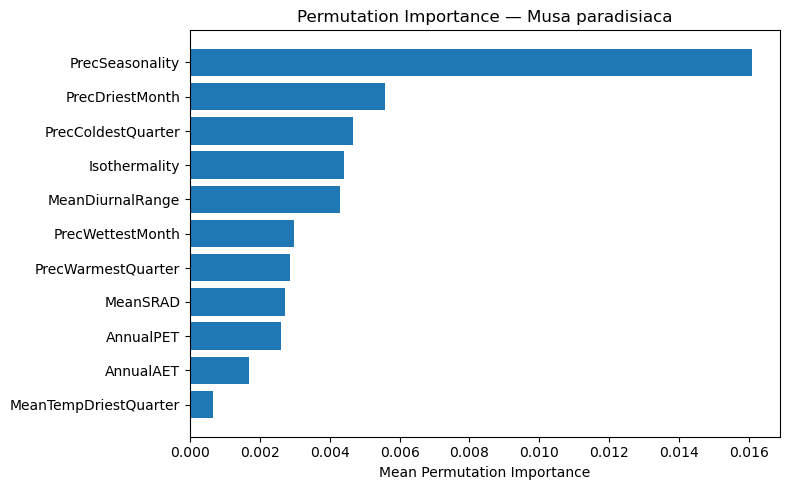

📉 Dropped correlated predictors: ['AnnualDeficit', 'MeanTempWettestQuarter']
🌳 AUC (holdout): 0.943
🎯 Threshold (max sens+spec): 0.15
🔁 Cross-val AUC: 0.949 ± 0.011


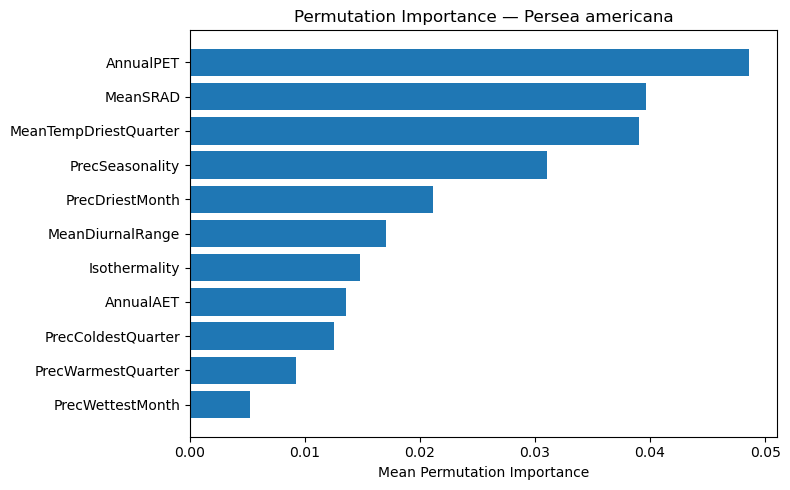

📉 Dropped correlated predictors: ['AnnualDeficit', 'MeanTempWettestQuarter']
🌳 AUC (holdout): 0.966
🎯 Threshold (max sens+spec): 0.13
🔁 Cross-val AUC: 0.953 ± 0.019


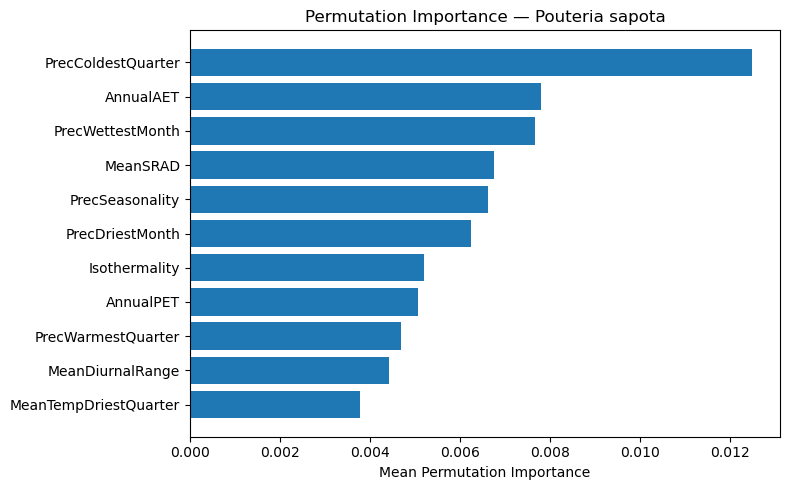

📉 Dropped correlated predictors: ['AnnualDeficit', 'MeanTempWettestQuarter']
🌳 AUC (holdout): 0.929
🎯 Threshold (max sens+spec): 0.38
🔁 Cross-val AUC: 0.945 ± 0.015


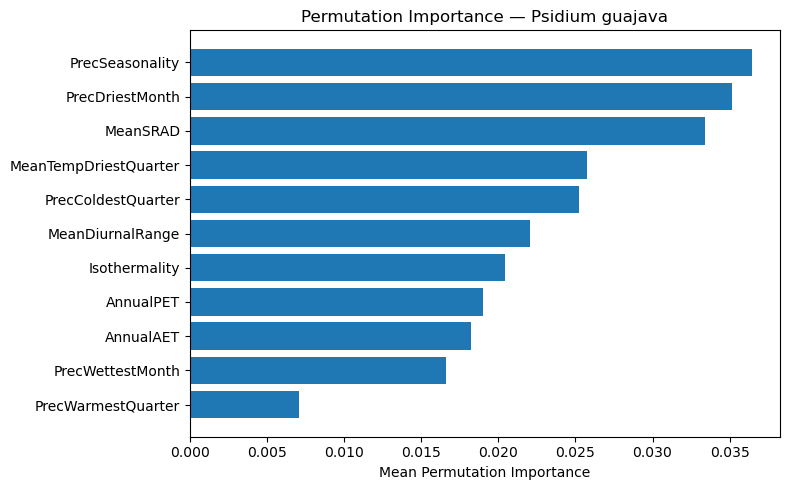

📉 Dropped correlated predictors: ['AnnualDeficit', 'MeanTempWettestQuarter']
🌳 AUC (holdout): 0.944
🎯 Threshold (max sens+spec): 0.16
🔁 Cross-val AUC: 0.951 ± 0.016


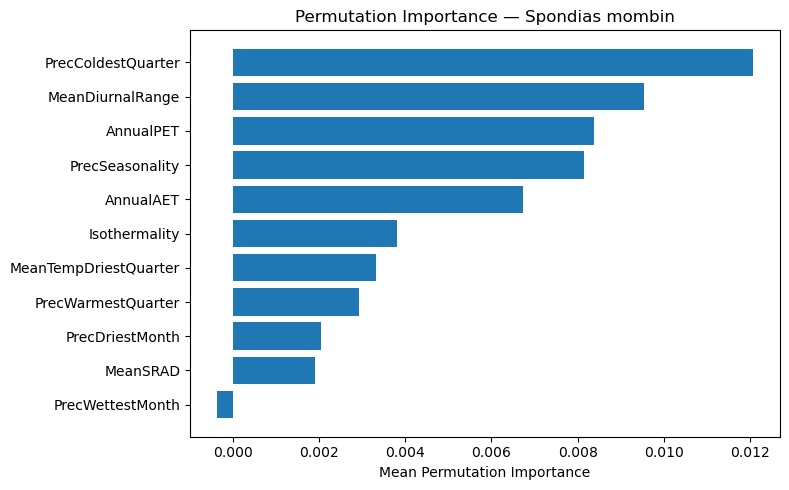

📉 Dropped correlated predictors: ['AnnualDeficit', 'MeanTempWettestQuarter']
🌳 AUC (holdout): 0.955
🎯 Threshold (max sens+spec): 0.17
🔁 Cross-val AUC: 0.975 ± 0.012


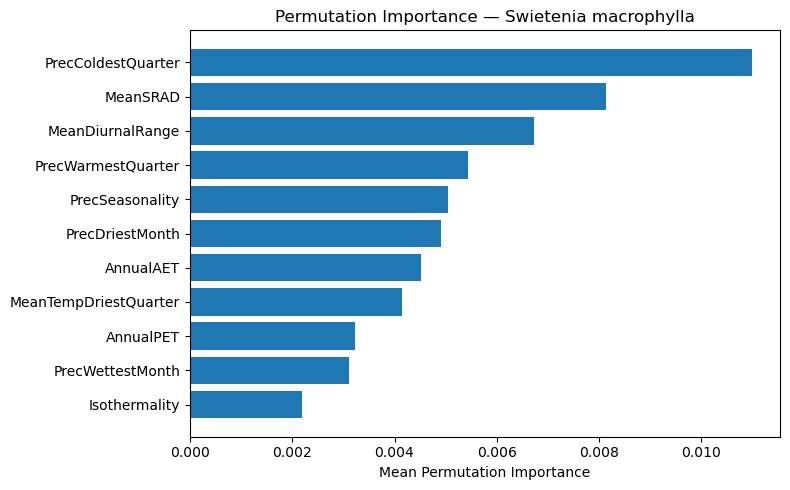

📉 Dropped correlated predictors: ['AnnualDeficit', 'MeanTempWettestQuarter']
🌳 AUC (holdout): 0.968
🎯 Threshold (max sens+spec): 0.22
🔁 Cross-val AUC: 0.969 ± 0.009


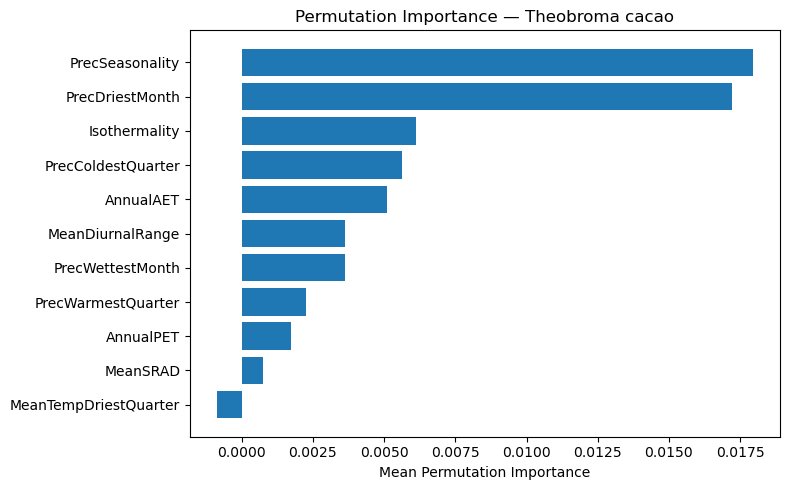

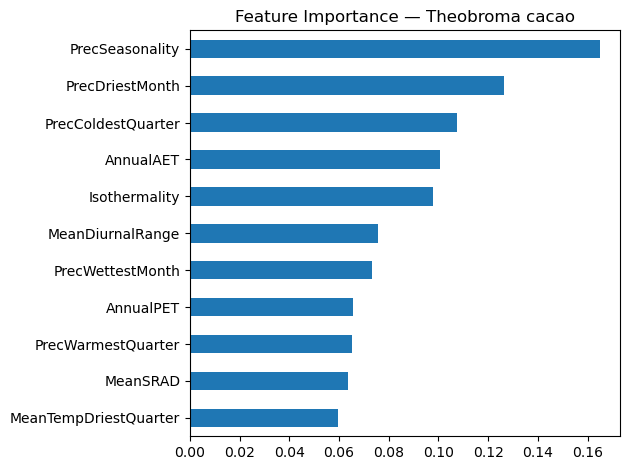

📉 Dropped correlated predictors: ['AnnualDeficit', 'MeanTempWettestQuarter']
🌳 AUC (holdout): 0.999
🎯 Threshold (max sens+spec): 0.08
🔁 Cross-val AUC: 0.998 ± 0.002


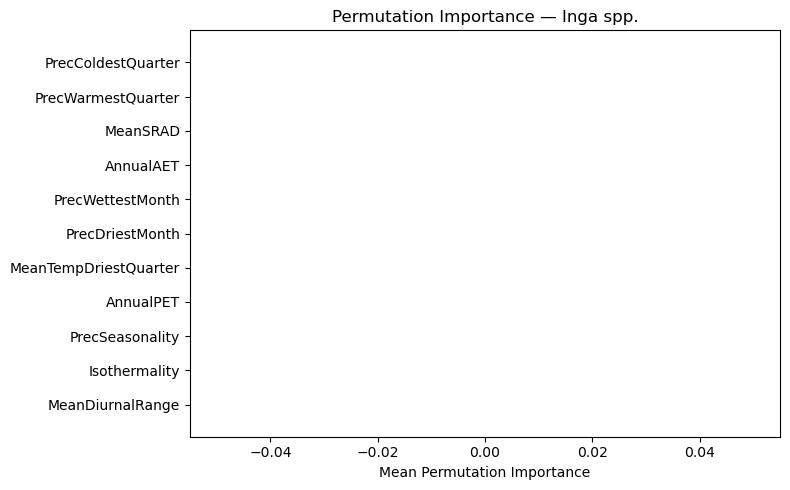


🎉 AUC summary:
Annona muricata: 0.977
Artocarpus altilis: 0.986
Byrsonima crassifolia: 0.946
Cajanus cajan: 0.983
Carica papaya: 0.960
Cedrela odorata: 0.925
Citrus aurantium: 0.948
Citrus sinensis: 0.961
Coffea arabica: 0.984
Cordia alliodora: 0.950
Erythrina poeppigiana: 0.994
Gliricidia sepium: 0.947
Inga edulis: 0.943
Inga jinicuil: 0.991
Inga vera: 0.946
Mangifera indica: 0.946
Musa paradisiaca: 0.963
Persea americana: 0.943
Pouteria sapota: 0.966
Psidium guajava: 0.929
Spondias mombin: 0.944
Swietenia macrophylla: 0.955
Theobroma cacao: 0.968
Inga spp.: 0.999


In [9]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.inspection import permutation_importance
from scipy.spatial import cKDTree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import requests
from shapely.geometry import Point

# =========================================
# SETTINGS
# =========================================
species_to_plot = ["Coffea arabica", "Theobroma cacao"]
min_distance_deg = 0.1
corr_threshold = 0.85
vif_threshold = 10
n_estimators = 300
min_importance = 0.01

selected_predictors = [
    "MeanDiurnalRange", "Isothermality", "PrecSeasonality", "AnnualPET",
    "MeanTempDriestQuarter", "PrecDriestMonth", "PrecWettestMonth", "AnnualAET",
    "AnnualDeficit", "MeanSRAD", "MeanTempWettestQuarter",
    "PrecWarmestQuarter", "PrecColdestQuarter"
]

# Expert base points (from you)
coffee_points = [
    Point(-71.243, 19.271),
    Point(-71.778, 19.404),
    Point(-70.981, 19.237),
    Point(-70.960, 19.670),
]
cacao_points = [
    Point(-71.125, 19.505),
    Point(-71.228, 19.602),
    Point(-71.606, 19.337),
]

EXPERT_POINTS = {
    "Coffea arabica": coffee_points,
    "Theobroma cacao": cacao_points,
}

EXPECTED_ALT = {
    "Coffea arabica": (600, 2000),
    "Theobroma cacao": (0, 800),
}




# =========================================
# TRAINING LOOP
# =========================================
auc_results = {}
results_by_species = {}
trained_classifiers = {}
feature_columns = {}
thresholds_by_species = {}
for species in data_all["species"].unique():
    if species == "background":
        continue

    df_presence = data_all[(data_all["species"] == species) & (data_all["presence"] == 1)].copy()
    df_background_all = data_all[data_all["presence"] == 0].copy()

    if len(df_presence) < 10:
        continue

    pres_coords = df_presence[["lon", "lat"]].to_numpy()
    tree = cKDTree(pres_coords)
    bg_far = []
    for _, row in df_background_all.iterrows():
        dist, _ = tree.query([row["lon"], row["lat"]], k=1)
        if dist >= min_distance_deg:
            bg_far.append(row)
    df_background = pd.DataFrame(bg_far)

    # --- Combine data ---
    df = pd.concat([df_presence, df_background], ignore_index=True)

    # --- Correlation filtering ---
    predictors_filtered, dropped_corr = drop_correlated(df, selected_predictors, corr_threshold)
    if dropped_corr:
        print(f"📉 Dropped correlated predictors: {dropped_corr}")

    # --- VIF filtering ---
    predictors_filtered, dropped_vif, vif_df = drop_high_vif(df, predictors_filtered, vif_threshold)
    if dropped_vif:
        print(f"📉 Dropped high-VIF predictors: {dropped_vif}")

    X = df[predictors_filtered]
    y = df["presence"]

    # --- Train/Test split ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # --- Train RF ---
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)

    # --- Drop low-importance features and retrain ---
    importances = pd.Series(clf.feature_importances_, index=predictors_filtered)
    low_imp = importances[importances < min_importance].index.tolist()
    if low_imp:
        print(f"📉 Dropping low-importance features: {low_imp}")
        predictors_filtered = [p for p in predictors_filtered if p not in low_imp]
        X_train = X_train[predictors_filtered]
        X_test = X_test[predictors_filtered]
        clf.fit(X_train, y_train)

    # --- Store classifier ---
    trained_classifiers[species] = clf
    feature_columns[species] = predictors_filtered

    # --- AUC on holdout ---
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_prob)
    auc_results[species] = auc
    print(f"🌳 AUC (holdout): {auc:.3f}")

    # --- Threshold ---
    threshold = max_sens_spec_threshold(y_test, y_pred_prob)
    print(f"🎯 Threshold (max sens+spec): {threshold:.2f}")

    # --- Cross-validation AUC ---
    cv_auc = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_idx, test_idx in cv.split(X, y):
        X_tr, X_te = X.iloc[train_idx][predictors_filtered], X.iloc[test_idx][predictors_filtered]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
        model_cv = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1)
        model_cv.fit(X_tr, y_tr)
        prob_te = model_cv.predict_proba(X_te)[:, 1]
        cv_auc.append(roc_auc_score(y_te, prob_te))

    print(f"🔁 Cross-val AUC: {np.mean(cv_auc):.3f} ± {np.std(cv_auc):.3f}")

    # --- Permutation importance ---
    perm = permutation_importance(clf, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)
    sorted_idx = perm.importances_mean.argsort()

    plt.figure(figsize=(8, 5))
    plt.barh(np.array(predictors_filtered)[sorted_idx], perm.importances_mean[sorted_idx])
    plt.xlabel("Mean Permutation Importance")
    plt.title(f"Permutation Importance — {species}")
    plt.tight_layout()
    plt.show()

    # --- Save predictions ---
    df["suitability"] = clf.predict_proba(X[predictors_filtered])[:, 1]
    df["predicted_presence"] = (df["suitability"] >= threshold).astype(int)
    results_by_species[species] = df

    # --- Feature importance plot ---
    if species in species_to_plot:
        importances = pd.Series(clf.feature_importances_, index=predictors_filtered).sort_values()
        importances.plot.barh()
        plt.title(f"Feature Importance — {species}")
        plt.tight_layout()
        plt.show()
    thresholds_by_species[species] = threshold
# =========================================
# SUMMARY
# =========================================
print("\n🎉 AUC summary:")
for k, v in auc_results.items():
    print(f"{k}: {v:.3f}")

df_all_results = pd.concat(results_by_species.values(), ignore_index=True)


In [10]:
thresholds_by_species

{'Annona muricata': 0.13,
 'Artocarpus altilis': 0.1,
 'Byrsonima crassifolia': 0.28,
 'Cajanus cajan': 0.09,
 'Carica papaya': 0.33,
 'Cedrela odorata': 0.15,
 'Citrus aurantium': 0.06,
 'Citrus sinensis': 0.08,
 'Coffea arabica': 0.28,
 'Cordia alliodora': 0.25,
 'Erythrina poeppigiana': 0.03,
 'Gliricidia sepium': 0.19,
 'Inga edulis': 0.2,
 'Inga jinicuil': 0.06,
 'Inga vera': 0.32,
 'Mangifera indica': 0.2,
 'Musa paradisiaca': 0.06,
 'Persea americana': 0.15,
 'Pouteria sapota': 0.13,
 'Psidium guajava': 0.38,
 'Spondias mombin': 0.16,
 'Swietenia macrophylla': 0.17,
 'Theobroma cacao': 0.22,
 'Inga spp.': 0.08}

# lets save those thresholds:

In [11]:
import json
from pathlib import Path

# 📂 Save thresholds in the current working directory
out_path = Path().cwd() / "species_thresholds.json"

with open(out_path, "w") as f:
    json.dump(thresholds_by_species, f, indent=2)

print(f"💾 Saved thresholds for {len(thresholds_by_species)} species to {out_path}")


💾 Saved thresholds for 24 species to /Users/szelie/python_projects/biofincas_climate_risk/agroforest_risk/species_thresholds.json


In [12]:
thresholds_by_species

{'Annona muricata': 0.13,
 'Artocarpus altilis': 0.1,
 'Byrsonima crassifolia': 0.28,
 'Cajanus cajan': 0.09,
 'Carica papaya': 0.33,
 'Cedrela odorata': 0.15,
 'Citrus aurantium': 0.06,
 'Citrus sinensis': 0.08,
 'Coffea arabica': 0.28,
 'Cordia alliodora': 0.25,
 'Erythrina poeppigiana': 0.03,
 'Gliricidia sepium': 0.19,
 'Inga edulis': 0.2,
 'Inga jinicuil': 0.06,
 'Inga vera': 0.32,
 'Mangifera indica': 0.2,
 'Musa paradisiaca': 0.06,
 'Persea americana': 0.15,
 'Pouteria sapota': 0.13,
 'Psidium guajava': 0.38,
 'Spondias mombin': 0.16,
 'Swietenia macrophylla': 0.17,
 'Theobroma cacao': 0.22,
 'Inga spp.': 0.08}

## Predicting Suitability Maps for Current and Future Climate

This cell uses the **trained Random Forest models** to predict species suitability  
across the study area for **current** and **future** climate conditions.

### Steps
1. **Prepare data**
   - Use `df_now` (current climate) and `df_future` (future climate).
   - Drop rows with missing predictor values for each species’ selected features.

2. **Generate predictions**
   - For each trained classifier (`trained_classifiers`):
     - Extract the relevant predictors (`feature_columns[species]`).
     - Predict suitability **for each grid cell**.

3. **Estimate prediction uncertainty**
   - Run predictions for each individual decision tree in the Random Forest.
   - Compute:
     - **Mean suitability** (`suitability`)
     - **Standard deviation** across trees (`suitability_std`)

4. **Save results**
   - Store both mean and std for:
     - `suitability_maps_now[species]` — current climate
     - `suitability_maps_future[species]` — future climate
   - Each entry contains:
     - `lon`, `lat`
     - Mean suitability score
     - Prediction uncertainty (std)

### Output
- `suitability_maps_now`: dict of DataFrames with suitability & uncertainty for each species (current climate).
- `suitability_maps_future`: same as above for future climate.


In [13]:
import pandas as pd
import numpy as np
import xarray as xr

def load_and_crop_climate_data(nc_path, bbox):
    """
    Load a NetCDF climate dataset, ensure lat/lon ordering,
    crop to bounding box, and return as a DataFrame without NaNs.

    Parameters
    ----------
    nc_path : str
        Path to the NetCDF file.
    bbox : tuple
        (min_lon, max_lon, min_lat, max_lat) bounding box.

    Returns
    -------
    pd.DataFrame
        Climate data for the selected bounding box.
    """
    # 📂 Load dataset
    ds = xr.open_dataset(nc_path)

    # 🔄 Ensure lat ascending
    if ds.lat.values[0] > ds.lat.values[-1]:
        ds = ds.reindex(lat=list(reversed(ds.lat)))

    # 🔄 Ensure lon in -180..180 range
    if ds.lon.max() > 180:
        ds = ds.assign_coords(lon=((ds.lon + 180) % 360) - 180)
    ds = ds.sortby("lon")

    # ✂️ Crop dataset to bbox
    lat_min, lat_max = sorted([bbox[2], bbox[3]])
    lon_min, lon_max = sorted([bbox[0], bbox[1]])
    ds_crop = ds.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

    # 🚿 Drop all-NaN grid cells
    ds_crop = ds_crop.dropna(dim="lat", how="all").dropna(dim="lon", how="all")

    # 📊 Convert to DataFrame
    df = ds_crop.to_dataframe().reset_index().dropna()

    return df

# 📍 Define bounding box
bbox = (-100.98, -68.0, 13.0, 21.98)

# 📄 Load current climate
df_now = load_and_crop_climate_data(
    DATA_DIR / "terra_climate/SuitabilityVariables_1990_2014.nc",
    bbox
)

# 📄 Load future climate
df_future = load_and_crop_climate_data(DATA_DIR / 
    "terra_climate_scenarios_ncss/plus2C/SuitabilityVariables_plus2C_1990_2014.nc",
    bbox
)

# 📄 Load future climate
df_4c = load_and_crop_climate_data(DATA_DIR / 
    "terra_climate_scenarios_ncss/plus4C/SuitabilityVariables_plus4C_1990_2014.nc",
    bbox
)

print(f"✅ df_now: {len(df_now)} grid points, df_future: {len(df_future)} grid points")


✅ df_now: 54037 grid points, df_future: 54037 grid points


In [14]:
suitability_maps_historical = {}
suitability_maps_2c = {}
suitability_maps_4c = {}

for species in trained_classifiers:
    clf = trained_classifiers[species]
    features = feature_columns[species]

    # Drop NaNs
    df_now_valid = df_now.dropna(subset=features).copy()
    df_2c_valid  = df_future.dropna(subset=features).copy()
    df_4c_valid  = df_4c.dropna(subset=features).copy()

    # Prepare design matrices as NumPy (avoids the warning)
    X_now = df_now_valid[features].to_numpy()
    X_2c  = df_2c_valid[features].to_numpy()
    X_4c  = df_4c_valid[features].to_numpy()

    # Historical
    tree_preds_hist = np.stack([tree.predict_proba(X_now)[:, 1] for tree in clf.estimators_], axis=1)
    df_now_valid["suitability"] = tree_preds_hist.mean(axis=1)
    df_now_valid["suitability_std"] = tree_preds_hist.std(axis=1)
    suitability_maps_historical[species] = df_now_valid[["lon", "lat", "suitability", "suitability_std"]]

    # 2°C
    tree_preds_2c = np.stack([tree.predict_proba(X_2c)[:, 1] for tree in clf.estimators_], axis=1)
    df_2c_valid["suitability"] = tree_preds_2c.mean(axis=1)
    df_2c_valid["suitability_std"] = tree_preds_2c.std(axis=1)
    suitability_maps_2c[species] = df_2c_valid[["lon", "lat", "suitability", "suitability_std"]]

    # 4°C
    tree_preds_4c = np.stack([tree.predict_proba(X_4c)[:, 1] for tree in clf.estimators_], axis=1)
    df_4c_valid["suitability"] = tree_preds_4c.mean(axis=1)
    df_4c_valid["suitability_std"] = tree_preds_4c.std(axis=1)
    suitability_maps_4c[species] = df_4c_valid[["lon", "lat", "suitability", "suitability_std"]]


# ==========================
# Save
# ==========================
import os
out_dir = str(DATA_DIR / "suitability")
os.makedirs(out_dir, exist_ok=True)

def save_suitability_dict(suit_dict, label):
    for species, df in suit_dict.items():
        fname = f"{label}_{species.replace(' ', '_')}.parquet"
        df.to_parquet(os.path.join(out_dir, fname), index=False)

save_suitability_dict(suitability_maps_historical, "historical")
save_suitability_dict(suitability_maps_2c, "2c")
save_suitability_dict(suitability_maps_4c, "4c")


💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/suitability_maps/Persea_americana_suitability_maps.png


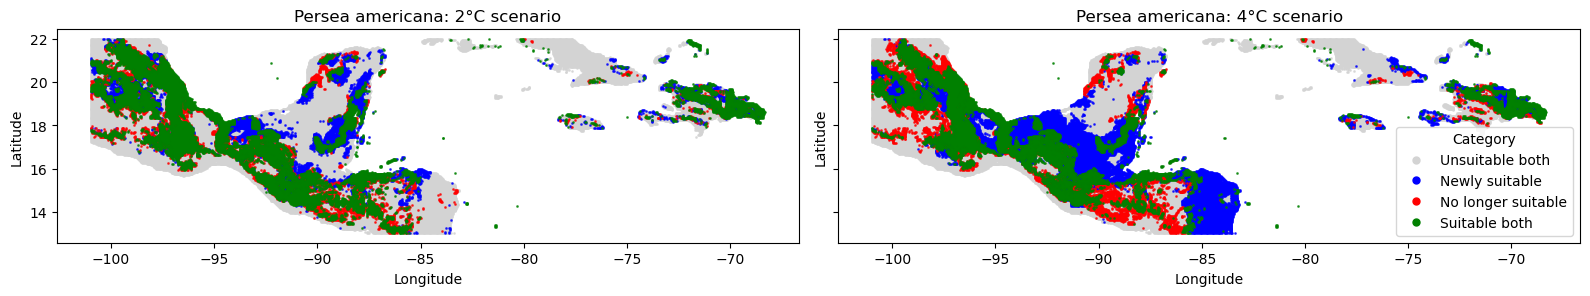

In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from shapely.geometry import Point
from config import FIGURES_DIR
subfolder = os.path.join(FIGURES_DIR, "suitability_maps")



# --- Species ---
species = 'Persea americana'

# --- Threshold from prevalence ---
threshold = thresholds_by_species[species]

# --- Get suitability for NOW, 2°C, and 4°C ---
df_now = suitability_maps_historical[species].copy()
df_2c = suitability_maps_2c[species].copy()
df_4c = suitability_maps_4c[species].copy()

# --- Rename columns ---
df_now = df_now.rename(columns={"suitability": "suit_now"})
df_2c = df_2c.rename(columns={"suitability": "suit_2c"})
df_4c = df_4c.rename(columns={"suitability": "suit_4c"})

# --- Merge with NOW ---
merge_2c = df_now.merge(df_2c[["lon", "lat", "suit_2c"]], on=["lon", "lat"], how="inner")
merge_4c = df_now.merge(df_4c[["lon", "lat", "suit_4c"]], on=["lon", "lat"], how="inner")

# --- Classify points ---
def classify_suitability(row, col_future):
    if row["suit_now"] >= threshold and row[col_future] >= threshold:
        return "Suitable both"
    elif row["suit_now"] < threshold and row[col_future] >= threshold:
        return "Newly suitable"
    elif row["suit_now"] >= threshold and row[col_future] < threshold:
        return "No longer suitable"
    else:
        return "Unsuitable both"

merge_2c["category"] = merge_2c.apply(lambda row: classify_suitability(row, "suit_2c"), axis=1)
merge_4c["category"] = merge_4c.apply(lambda row: classify_suitability(row, "suit_4c"), axis=1)

# --- Convert to GeoDataFrames ---
merge_2c["geometry"] = [Point(xy) for xy in zip(merge_2c["lon"], merge_2c["lat"])]
merge_4c["geometry"] = [Point(xy) for xy in zip(merge_4c["lon"], merge_4c["lat"])]

gdf_2c = gpd.GeoDataFrame(merge_2c, geometry="geometry", crs="EPSG:4326")
gdf_4c = gpd.GeoDataFrame(merge_4c, geometry="geometry", crs="EPSG:4326")

# --- Colors ---
category_colors = {
    "Unsuitable both": "lightgrey",
    "Newly suitable": "blue",
    "No longer suitable": "red",
    "Suitable both": "green",
}

# --- Create figure with two maps ---
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

for ax, gdf, title in zip(
    axs,
    [gdf_2c, gdf_4c],
    [f"{species}: 2°C scenario", f"{species}: 4°C scenario"]
):
    for category, color in category_colors.items():
        subset = gdf[gdf["category"] == category]
        if not subset.empty:
            subset.plot(ax=ax, color=color, markersize=1, alpha=0.7)
        else:
            ax.plot([], [], color=color)  # Dummy for legend

    ax.set_title(f"{title}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

# --- Custom legend (same for both) ---
legend_handles = [
    mlines.Line2D([], [], color=color, marker='o', linestyle='None',
                  markersize=5, label=category)
    for category, color in category_colors.items()
]
axs[1].legend(handles=legend_handles, title="Category", loc="lower right")

plt.tight_layout()
# --- Save to FIGURES_DIR/suitability_maps ---
os.makedirs(subfolder, exist_ok=True)

fname = f"{species.replace(' ', '_')}_suitability_maps.png"
outpath = os.path.join(subfolder, fname)
plt.savefig(outpath, dpi=300, bbox_inches="tight")
print(f"💾 Saved: {outpath}")


💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/suitability_maps/Coffea_arabica_suitability_maps.png


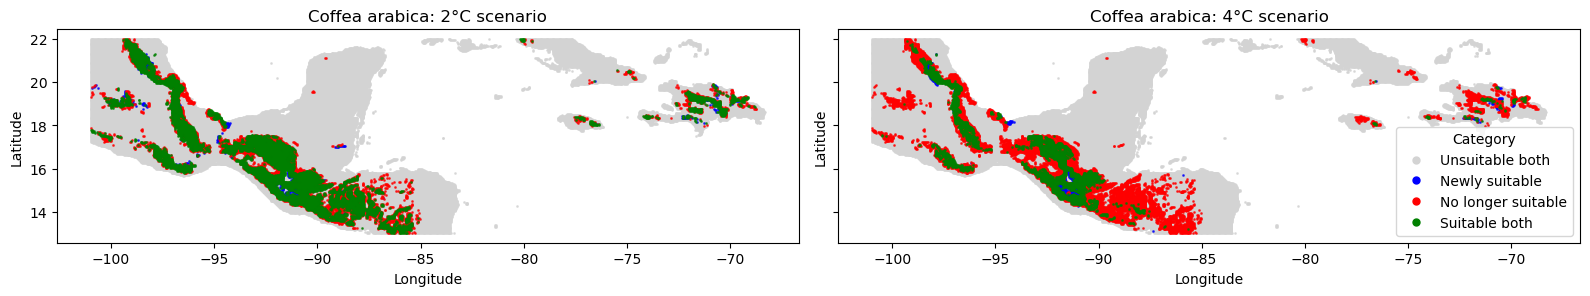

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from shapely.geometry import Point

# --- Species ---
species = "Coffea arabica"

# --- Threshold from prevalence ---
coffee_threshold = thresholds_by_species[species]

# --- Get suitability for NOW, 2°C, and 4°C ---
df_now = suitability_maps_historical[species].copy()
df_2c = suitability_maps_2c[species].copy()
df_4c = suitability_maps_4c[species].copy()

# --- Rename columns ---
df_now = df_now.rename(columns={"suitability": "suit_now"})
df_2c = df_2c.rename(columns={"suitability": "suit_2c"})
df_4c = df_4c.rename(columns={"suitability": "suit_4c"})

# --- Merge with NOW ---
merge_2c = df_now.merge(df_2c[["lon", "lat", "suit_2c"]], on=["lon", "lat"], how="inner")
merge_4c = df_now.merge(df_4c[["lon", "lat", "suit_4c"]], on=["lon", "lat"], how="inner")

# --- Classify points ---
def classify_suitability(row, col_future):
    if row["suit_now"] >= coffee_threshold and row[col_future] >= coffee_threshold:
        return "Suitable both"
    elif row["suit_now"] < coffee_threshold and row[col_future] >= coffee_threshold:
        return "Newly suitable"
    elif row["suit_now"] >= coffee_threshold and row[col_future] < coffee_threshold:
        return "No longer suitable"
    else:
        return "Unsuitable both"

merge_2c["category"] = merge_2c.apply(lambda row: classify_suitability(row, "suit_2c"), axis=1)
merge_4c["category"] = merge_4c.apply(lambda row: classify_suitability(row, "suit_4c"), axis=1)

# --- Convert to GeoDataFrames ---
merge_2c["geometry"] = [Point(xy) for xy in zip(merge_2c["lon"], merge_2c["lat"])]
merge_4c["geometry"] = [Point(xy) for xy in zip(merge_4c["lon"], merge_4c["lat"])]

gdf_2c = gpd.GeoDataFrame(merge_2c, geometry="geometry", crs="EPSG:4326")
gdf_4c = gpd.GeoDataFrame(merge_4c, geometry="geometry", crs="EPSG:4326")

# --- Colors ---
category_colors = {
    "Unsuitable both": "lightgrey",
    "Newly suitable": "blue",
    "No longer suitable": "red",
    "Suitable both": "green",
}

# --- Create figure with two maps ---
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

for ax, gdf, title in zip(
    axs,
    [gdf_2c, gdf_4c],
    [f"{species}: 2°C scenario", f"{species}: 4°C scenario"]
):
    for category, color in category_colors.items():
        subset = gdf[gdf["category"] == category]
        if not subset.empty:
            subset.plot(ax=ax, color=color, markersize=1, alpha=0.7)
        else:
            ax.plot([], [], color=color)  # Dummy for legend

    ax.set_title(f"{title}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

# --- Custom legend (same for both) ---
legend_handles = [
    mlines.Line2D([], [], color=color, marker='o', linestyle='None',
                  markersize=5, label=category)
    for category, color in category_colors.items()
]
axs[1].legend(handles=legend_handles, title="Category", loc="lower right")

plt.tight_layout()
os.makedirs(subfolder, exist_ok=True)

fname = f"{species.replace(' ', '_')}_suitability_maps.png"
outpath = os.path.join(subfolder, fname)
plt.savefig(outpath, dpi=300, bbox_inches="tight")
print(f"💾 Saved: {outpath}")

💾 Saved: /Users/szelie/Dropbox/Applications/Overleaf/biodiversity_climate_coffee_cacao/figures/suitability_maps/Theobroma_cacao_suitability_maps.png


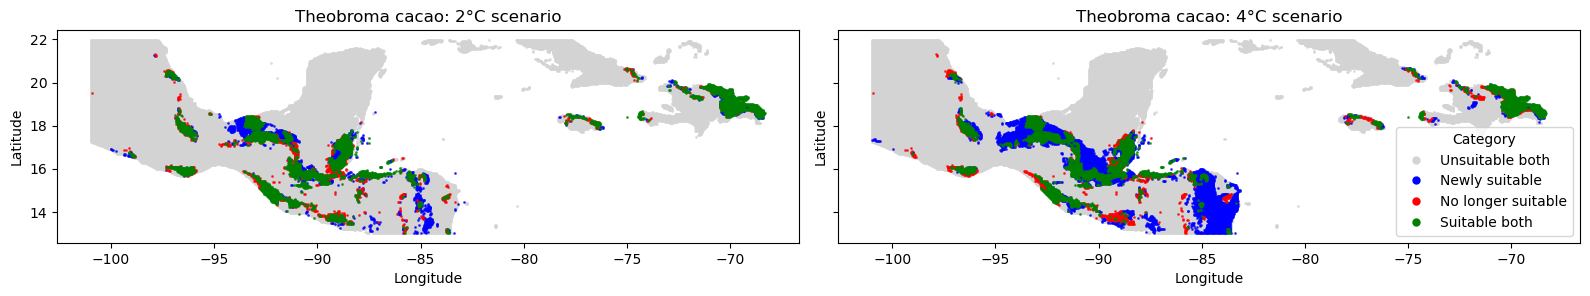

In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from shapely.geometry import Point

# --- Species ---
species = 'Theobroma cacao'

# --- Threshold from prevalence ---
threshold = thresholds_by_species[species]

# --- Get suitability for NOW, 2°C, and 4°C ---
df_now = suitability_maps_historical[species].copy()
df_2c = suitability_maps_2c[species].copy()
df_4c = suitability_maps_4c[species].copy()

# --- Rename columns ---
df_now = df_now.rename(columns={"suitability": "suit_now"})
df_2c = df_2c.rename(columns={"suitability": "suit_2c"})
df_4c = df_4c.rename(columns={"suitability": "suit_4c"})

# --- Merge with NOW ---
merge_2c = df_now.merge(df_2c[["lon", "lat", "suit_2c"]], on=["lon", "lat"], how="inner")
merge_4c = df_now.merge(df_4c[["lon", "lat", "suit_4c"]], on=["lon", "lat"], how="inner")

# --- Classify points ---
def classify_suitability(row, col_future):
    if row["suit_now"] >= threshold and row[col_future] >= threshold:
        return "Suitable both"
    elif row["suit_now"] < threshold and row[col_future] >= threshold:
        return "Newly suitable"
    elif row["suit_now"] >= threshold and row[col_future] < threshold:
        return "No longer suitable"
    else:
        return "Unsuitable both"

merge_2c["category"] = merge_2c.apply(lambda row: classify_suitability(row, "suit_2c"), axis=1)
merge_4c["category"] = merge_4c.apply(lambda row: classify_suitability(row, "suit_4c"), axis=1)

# --- Convert to GeoDataFrames ---
merge_2c["geometry"] = [Point(xy) for xy in zip(merge_2c["lon"], merge_2c["lat"])]
merge_4c["geometry"] = [Point(xy) for xy in zip(merge_4c["lon"], merge_4c["lat"])]

gdf_2c = gpd.GeoDataFrame(merge_2c, geometry="geometry", crs="EPSG:4326")
gdf_4c = gpd.GeoDataFrame(merge_4c, geometry="geometry", crs="EPSG:4326")

# --- Colors ---
category_colors = {
    "Unsuitable both": "lightgrey",
    "Newly suitable": "blue",
    "No longer suitable": "red",
    "Suitable both": "green",
}

# --- Create figure with two maps ---
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

for ax, gdf, title in zip(
    axs,
    [gdf_2c, gdf_4c],
    [f"{species}: 2°C scenario", f"{species}: 4°C scenario"]
):
    for category, color in category_colors.items():
        subset = gdf[gdf["category"] == category]
        if not subset.empty:
            subset.plot(ax=ax, color=color, markersize=1, alpha=0.7)
        else:
            ax.plot([], [], color=color)  # Dummy for legend

    ax.set_title(f"{title}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

# --- Custom legend (same for both) ---
legend_handles = [
    mlines.Line2D([], [], color=color, marker='o', linestyle='None',
                  markersize=5, label=category)
    for category, color in category_colors.items()
]
axs[1].legend(handles=legend_handles, title="Category", loc="lower right")

plt.tight_layout()
os.makedirs(subfolder, exist_ok=True)

fname = f"{species.replace(' ', '_')}_suitability_maps.png"
outpath = os.path.join(subfolder, fname)
plt.savefig(outpath, dpi=300, bbox_inches="tight")
print(f"💾 Saved: {outpath}")


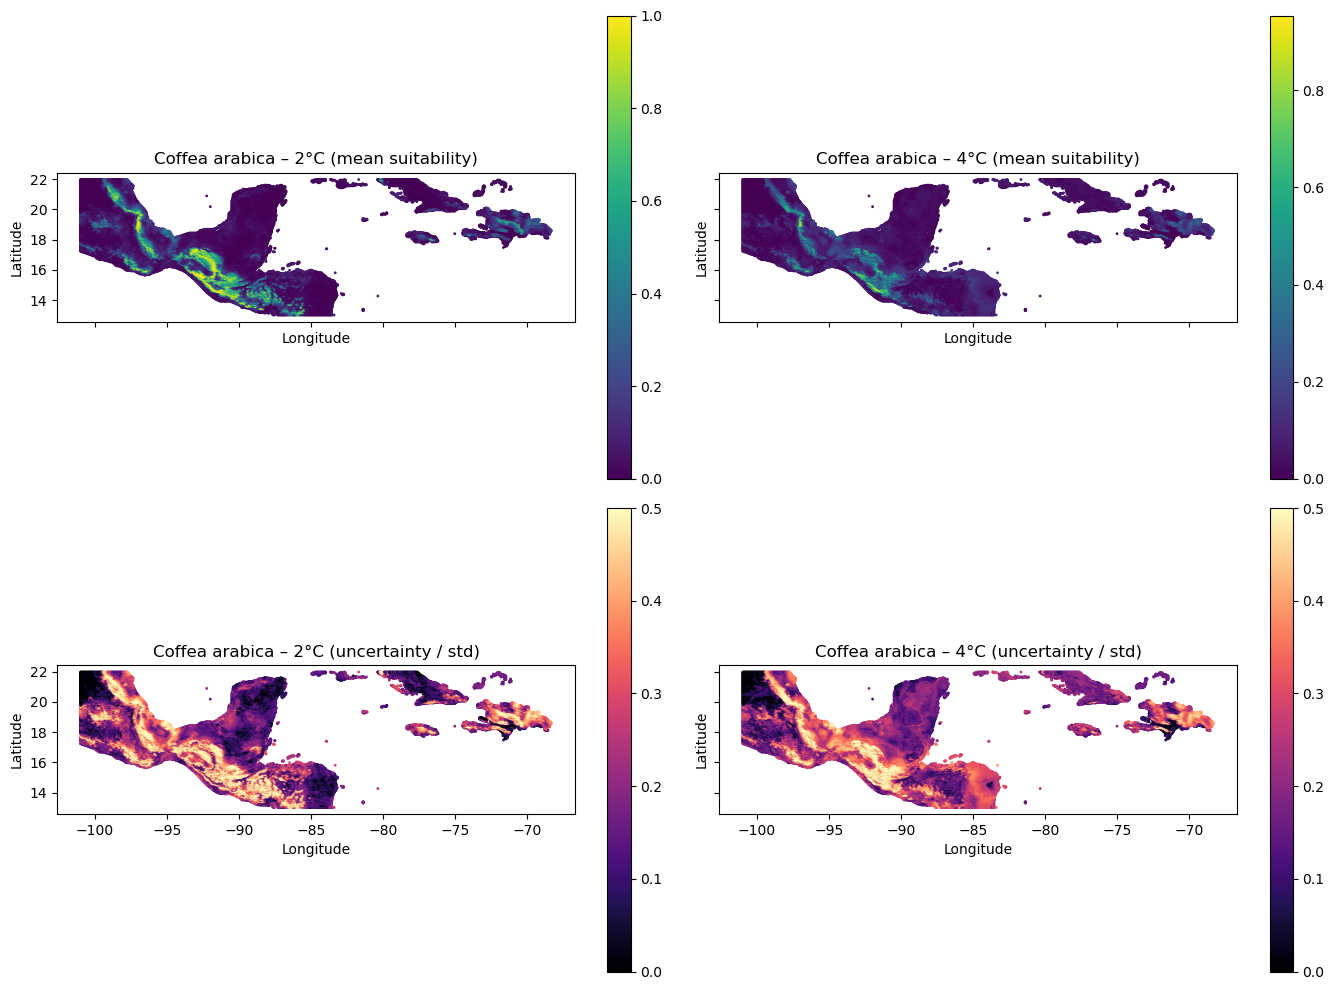

In [18]:
import matplotlib.pyplot as plt

# --- Species to plot ---
species = "Coffea arabica"

# --- Load suitability + std ---
gdf_now = suitability_maps_historical[species].copy()
gdf_2c  = suitability_maps_2c[species].copy()
gdf_4c  = suitability_maps_4c[species].copy()

# --- Convert to GeoDataFrames ---
for gdf in [gdf_now, gdf_2c, gdf_4c]:
    gdf["geometry"] = [Point(xy) for xy in zip(gdf["lon"], gdf["lat"])]
gdf_now = gpd.GeoDataFrame(gdf_now, crs="EPSG:4326")
gdf_2c  = gpd.GeoDataFrame(gdf_2c,  crs="EPSG:4326")
gdf_4c  = gpd.GeoDataFrame(gdf_4c,  crs="EPSG:4326")

# --- Figure with 2 rows: mean suitability & std ---
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

# Row 1: mean suitability
gdf_2c.plot(ax=axs[0,0], column="suitability", cmap="viridis",
            markersize=1, legend=True)
axs[0,0].set_title(f"{species} – 2°C (mean suitability)")

gdf_4c.plot(ax=axs[0,1], column="suitability", cmap="viridis",
            markersize=1, legend=True)
axs[0,1].set_title(f"{species} – 4°C (mean suitability)")

# Row 2: std (uncertainty)
gdf_2c.plot(ax=axs[1,0], column="suitability_std", cmap="magma",
            markersize=1, legend=True)
axs[1,0].set_title(f"{species} – 2°C (uncertainty / std)")

gdf_4c.plot(ax=axs[1,1], column="suitability_std", cmap="magma",
            markersize=1, legend=True)
axs[1,1].set_title(f"{species} – 4°C (uncertainty / std)")

for ax in axs.flat:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()


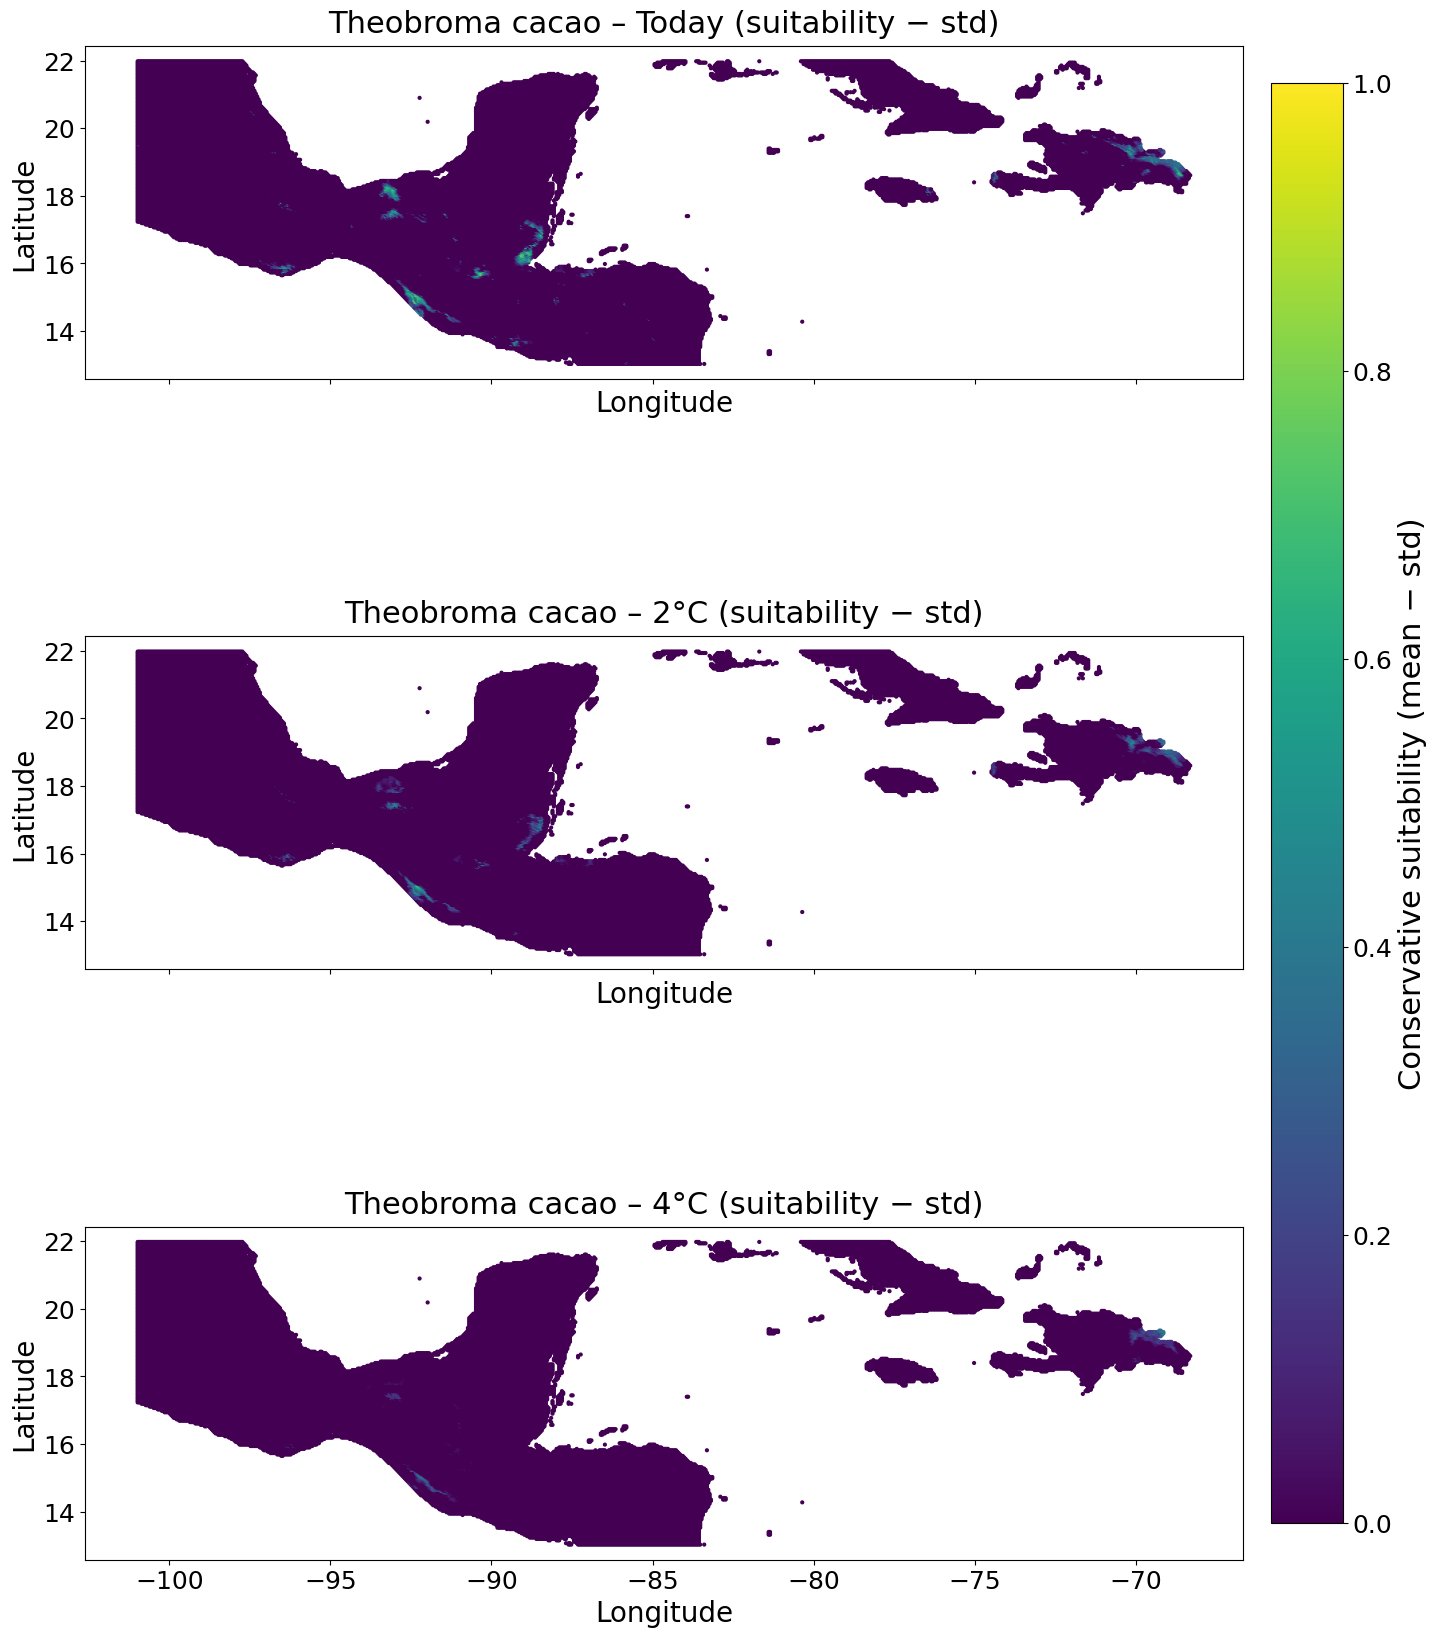

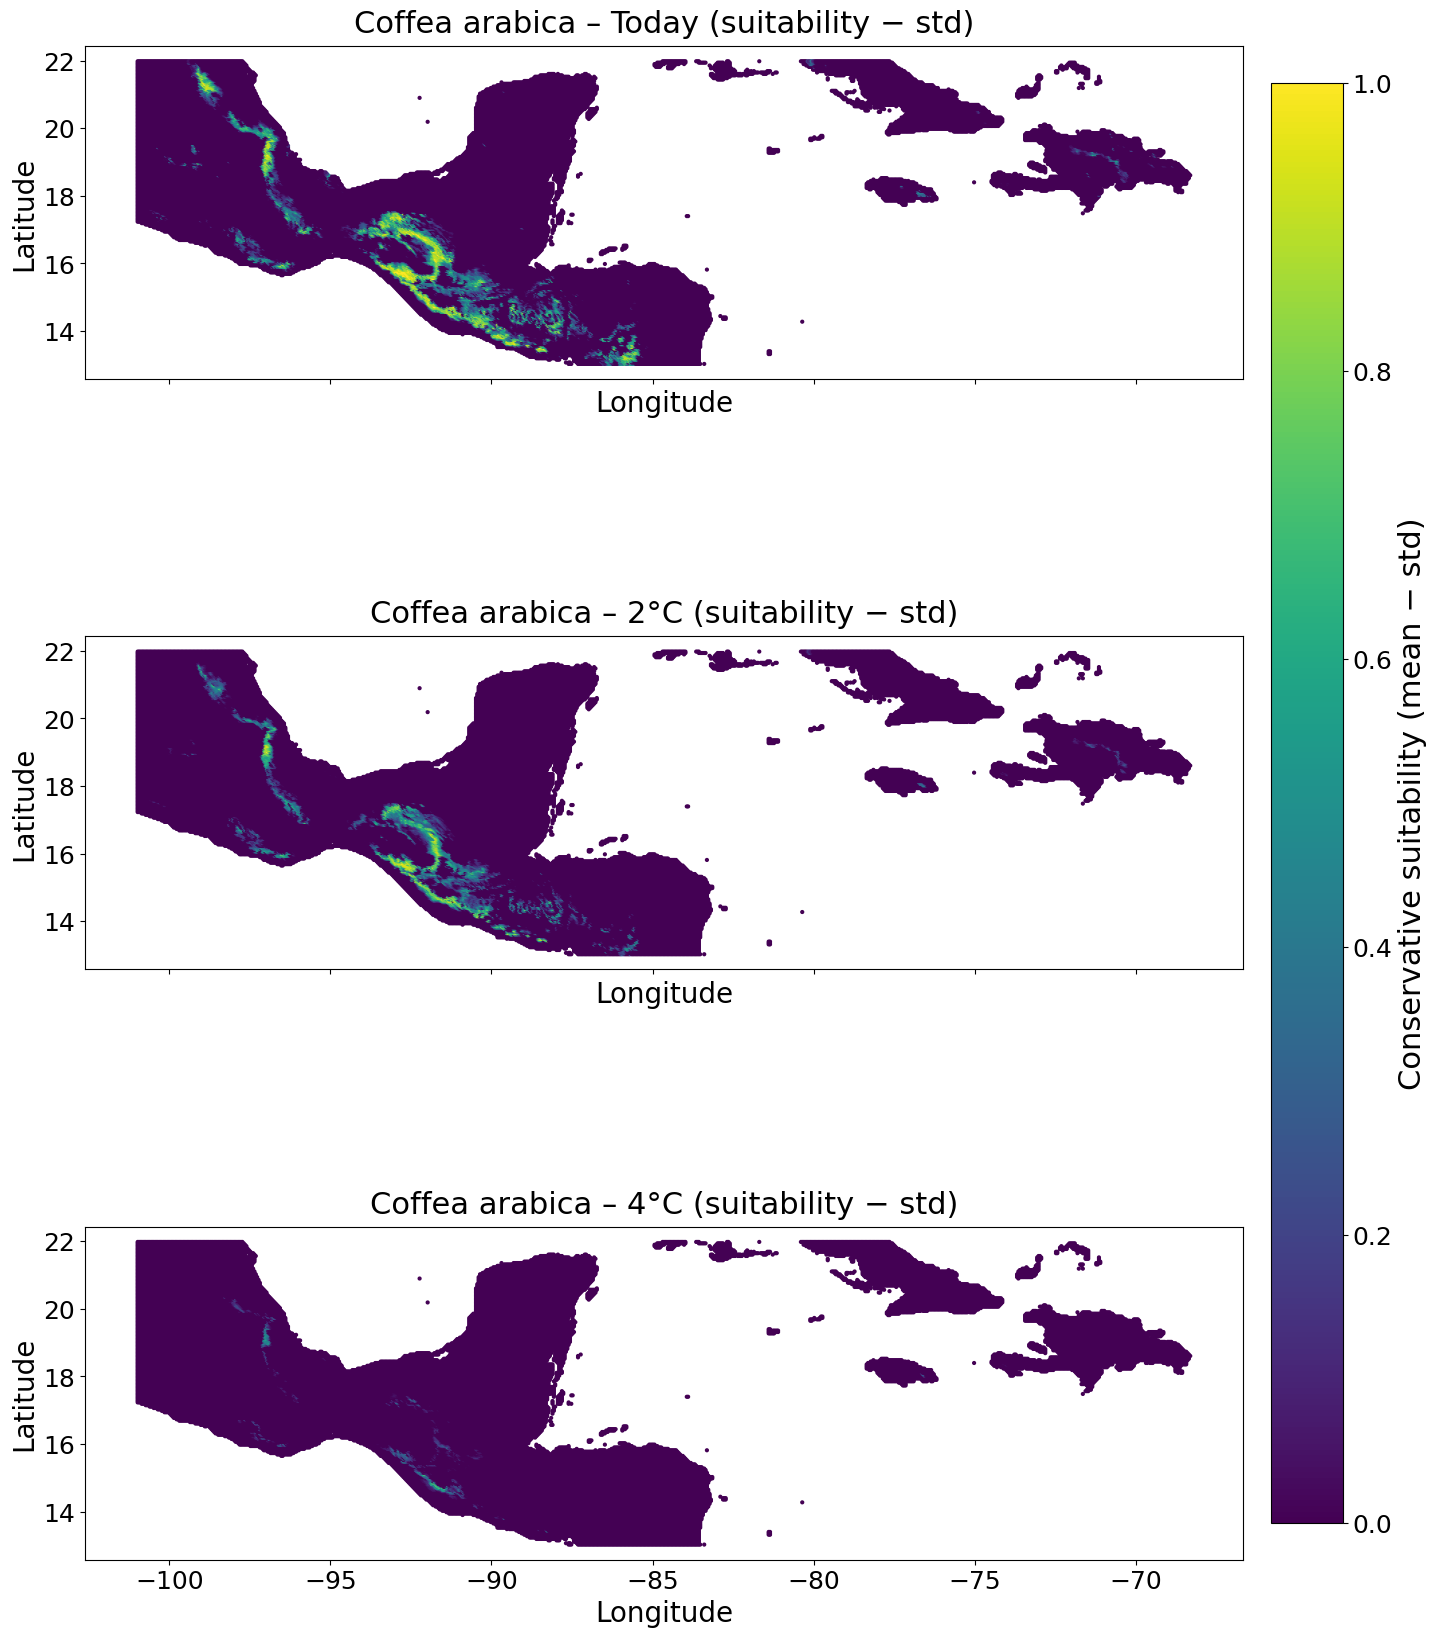

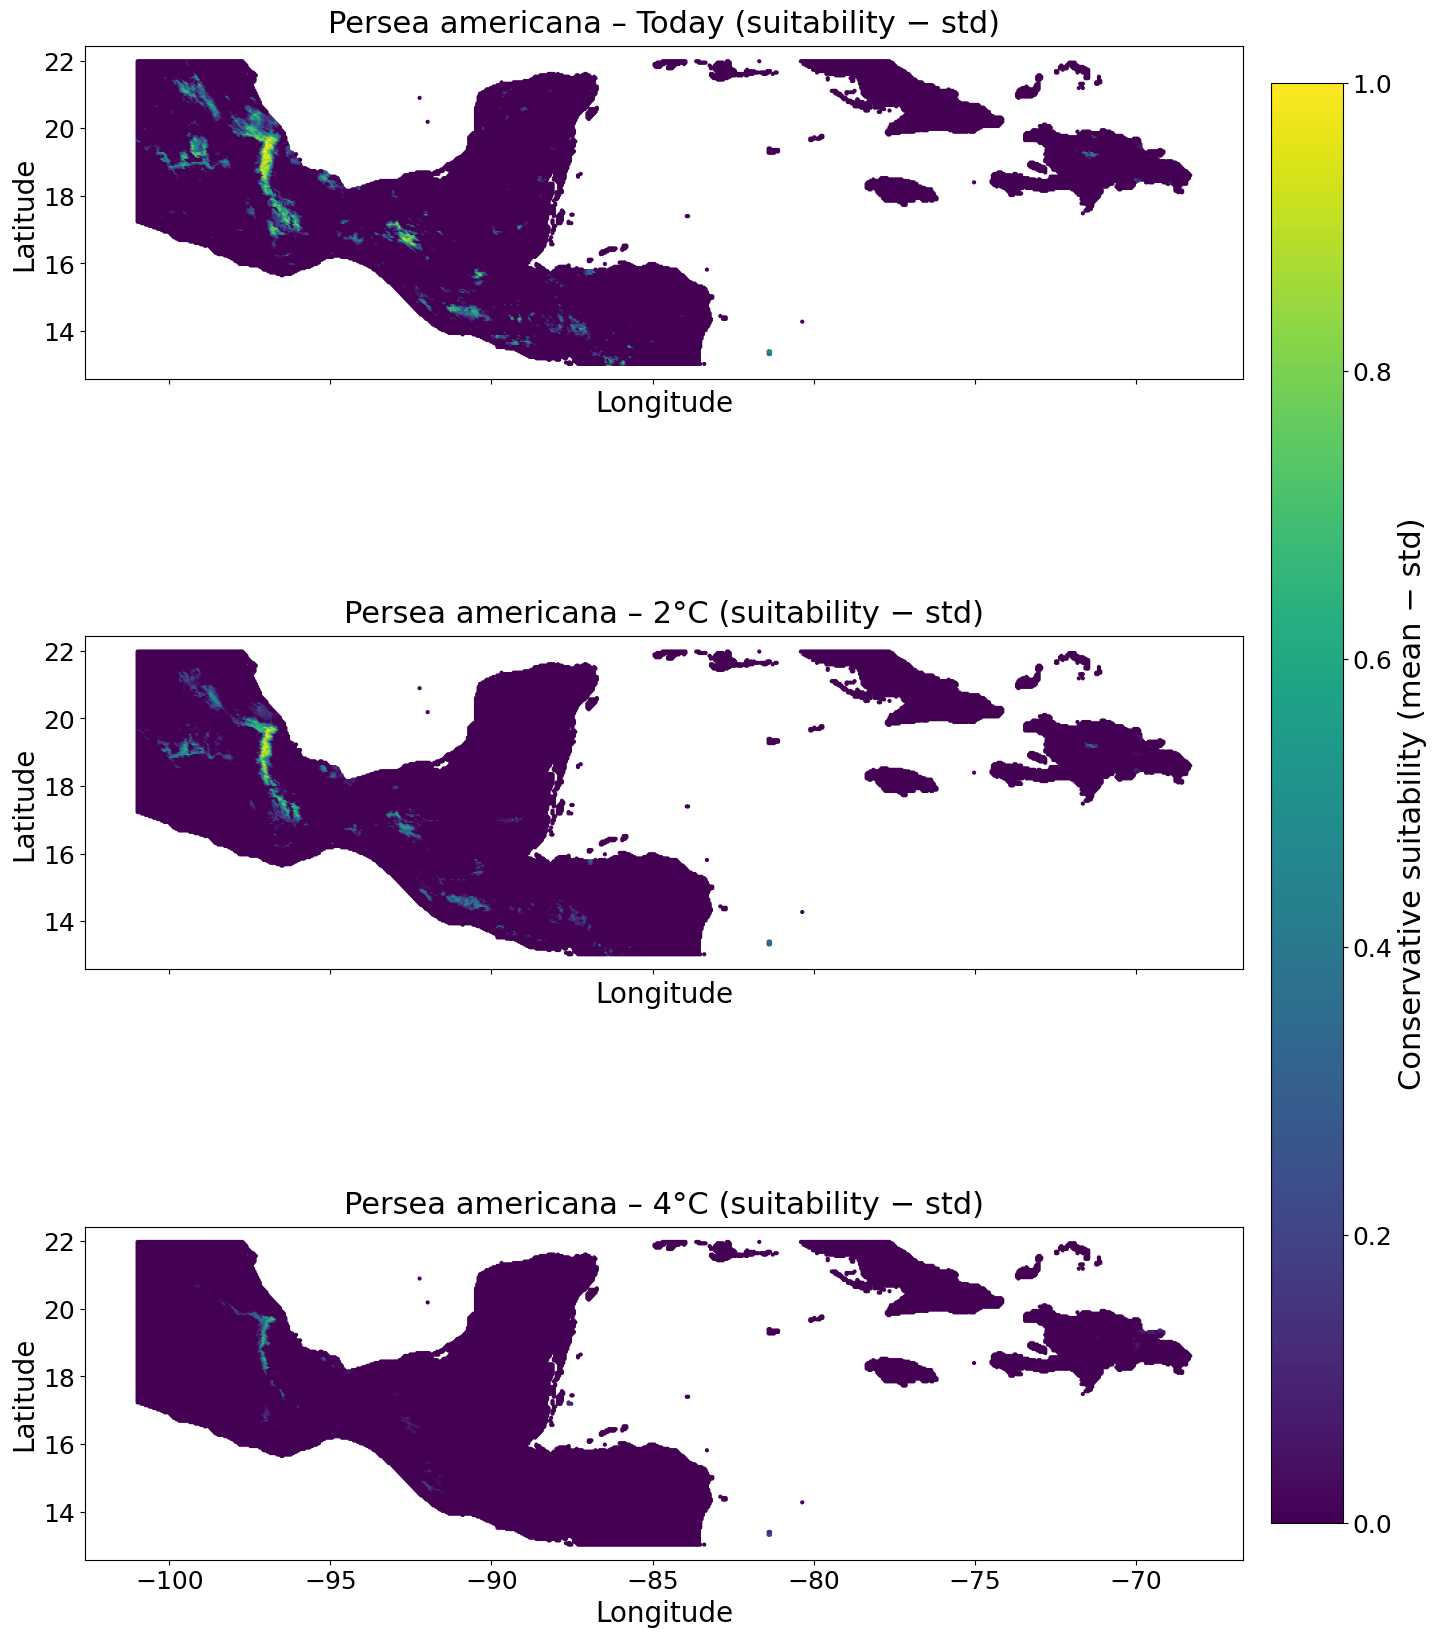

In [19]:
import matplotlib.pyplot as plt

# --- Species ---
species_list = ['Theobroma cacao', 'Coffea arabica', 'Persea americana']

for species in species_list:

# --- Get the right GeoDataFrames for this species ---
    df_now = suitability_maps_historical[species].copy()
    df_2c  = suitability_maps_2c[species].copy()
    df_4c  = suitability_maps_4c[species].copy()
    
    # Convert to GeoDataFrames
    from shapely.geometry import Point
    import geopandas as gpd
    
    for df in [df_now, df_2c, df_4c]:
        df["geometry"] = [Point(xy) for xy in zip(df["lon"], df["lat"])]
    
    gdf_now = gpd.GeoDataFrame(df_now, geometry="geometry", crs="EPSG:4326")
    gdf_2c  = gpd.GeoDataFrame(df_2c,  geometry="geometry", crs="EPSG:4326")
    gdf_4c  = gpd.GeoDataFrame(df_4c,  geometry="geometry", crs="EPSG:4326")
    
    # Compute lower bound = mean - std (clip at 0)
    gdf_now["suitability_lower"] = (gdf_now["suitability"] - gdf_now["suitability_std"]).clip(lower=0)
    gdf_2c["suitability_lower"]  = (gdf_2c["suitability"]  - gdf_2c["suitability_std"]).clip(lower=0)
    gdf_4c["suitability_lower"]  = (gdf_4c["suitability"]  - gdf_4c["suitability_std"]).clip(lower=0)
    
    # --- Style ---
    plt.rcParams.update({
        "axes.titlesize": 22,
        "axes.labelsize": 20,
        "xtick.labelsize": 18,
        "ytick.labelsize": 18,
    })
    
    # --- Create figure with space for colorbar ---
    fig, axs = plt.subplots(
        3, 1, figsize=(18, 22),
        sharex=True, sharey=True,
        gridspec_kw={"hspace": 0.15}  # reduce vertical spacing
    )
    
    plots = []
    titles = ["Today (suitability − std)",
              "2°C (suitability − std)",
              "4°C (suitability − std)"]
    
    for ax, gdf, title in zip(axs, [gdf_now, gdf_2c, gdf_4c], titles):
        p = gdf.plot(
            ax=ax,
            column="suitability_lower",
            cmap="viridis",
            markersize=4,
            vmin=0,
            vmax=1,
            legend=False
        )
        plots.append(p)
        ax.set_title(f"{species} – {title}", pad=10)
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
    
    # --- Add big colorbar on the right ---
    # Use the last collection as reference for colorbar
    cbar = fig.colorbar(
        plots[0].collections[0],
        ax=axs,
        orientation="vertical",
        shrink=0.85,   # makes it cover ~85% of figure height
        pad=0.02
    )
    cbar.set_label("Conservative suitability (mean − std)", fontsize=22)
    cbar.ax.tick_params(labelsize=18)
    
    plt.show()


In [20]:
thresholds_by_species

{'Annona muricata': 0.13,
 'Artocarpus altilis': 0.1,
 'Byrsonima crassifolia': 0.28,
 'Cajanus cajan': 0.09,
 'Carica papaya': 0.33,
 'Cedrela odorata': 0.15,
 'Citrus aurantium': 0.06,
 'Citrus sinensis': 0.08,
 'Coffea arabica': 0.28,
 'Cordia alliodora': 0.25,
 'Erythrina poeppigiana': 0.03,
 'Gliricidia sepium': 0.19,
 'Inga edulis': 0.2,
 'Inga jinicuil': 0.06,
 'Inga vera': 0.32,
 'Mangifera indica': 0.2,
 'Musa paradisiaca': 0.06,
 'Persea americana': 0.15,
 'Pouteria sapota': 0.13,
 'Psidium guajava': 0.38,
 'Spondias mombin': 0.16,
 'Swietenia macrophylla': 0.17,
 'Theobroma cacao': 0.22,
 'Inga spp.': 0.08}

In [21]:
import numpy as np
from scipy.spatial import cKDTree

def extract_nearest_suitability(obs_df, suit_df, col_name):
    """Map obs points to nearest suitability grid cell."""
    # Build tree from suitability grid
    coords_grid = np.vstack([suit_df["lon"].values, suit_df["lat"].values]).T
    tree = cKDTree(coords_grid)

    # Query nearest grid cell for each obs point
    coords_obs = np.vstack([obs_df["lon"].values, obs_df["lat"].values]).T
    dist, idx = tree.query(coords_obs)

    # Add suitability value
    obs_df[col_name] = suit_df.iloc[idx][col_name].values
    return obs_df
results = []

for sp in ["Coffea arabica", "Theobroma cacao"]:
    obs = occ_all[occ_all["species"] == sp][["lon", "lat"]].drop_duplicates()

    df_now = suitability_maps_historical[sp].rename(columns={"suitability": "suit_now"})
    df_2c  = suitability_maps_2c[sp].rename(columns={"suitability": "suit_2c"})
    df_4c  = suitability_maps_4c[sp].rename(columns={"suitability": "suit_4c"})

    # Extract nearest suitability for each obs point
    obs = extract_nearest_suitability(obs, df_now, "suit_now")
    obs = extract_nearest_suitability(obs, df_2c, "suit_2c")
    obs = extract_nearest_suitability(obs, df_4c, "suit_4c")

    # Threshold
    th = thresholds_by_species[sp]

    avg_loss_2c = (obs["suit_now"] - obs["suit_2c"]).mean()
    avg_loss_4c = (obs["suit_now"] - obs["suit_4c"]).mean()

    frac_unsuit_2c = ((obs["suit_now"] >= th) & (obs["suit_2c"] < th)).mean()
    frac_unsuit_4c = ((obs["suit_now"] >= th) & (obs["suit_4c"] < th)).mean()

    results.append({
        "species": sp,
        "avg_loss_2c": avg_loss_2c,
        "avg_loss_4c": avg_loss_4c,
        "frac_unsuitable_2c": frac_unsuit_2c,
        "frac_unsuitable_4c": frac_unsuit_4c,
        "n_obs": len(obs)
    })

summary_obs = pd.DataFrame(results)
display(summary_obs)


,species,avg_loss_2c,avg_loss_4c,frac_unsuitable_2c,frac_unsuitable_4c,n_obs
0,Coffea arabica,0.198411,0.532432,0.088455,0.494543,1741
1,Theobroma cacao,0.104961,0.138680,0.062745,0.113725,510


In [22]:
import numpy as np
from scipy.spatial import cKDTree

def extract_nearest_suitability(obs_df, suit_df, col_name):
    """Map obs points to nearest suitability grid cell."""
    # Build tree from suitability grid
    coords_grid = np.vstack([suit_df["lon"].values, suit_df["lat"].values]).T
    tree = cKDTree(coords_grid)

    # Query nearest grid cell for each obs point
    coords_obs = np.vstack([obs_df["lon"].values, obs_df["lat"].values]).T
    dist, idx = tree.query(coords_obs)

    # Add suitability value
    obs_df[col_name] = suit_df.iloc[idx][col_name].values
    return obs_df
results = []

for sp in occ_all['species'].unique():
    try:
        obs = occ_all[occ_all["species"] == sp][["lon", "lat"]].drop_duplicates()
    
        df_now = suitability_maps_historical[sp].rename(columns={"suitability": "suit_now"})
        df_2c  = suitability_maps_2c[sp].rename(columns={"suitability": "suit_2c"})
        df_4c  = suitability_maps_4c[sp].rename(columns={"suitability": "suit_4c"})
    
        # Extract nearest suitability for each obs point
        obs = extract_nearest_suitability(obs, df_now, "suit_now")
        obs = extract_nearest_suitability(obs, df_2c, "suit_2c")
        obs = extract_nearest_suitability(obs, df_4c, "suit_4c")
    
        # Threshold
        th = thresholds_by_species[sp]
    
        avg_loss_2c = (obs["suit_now"] - obs["suit_2c"]).mean()
        avg_loss_4c = (obs["suit_now"] - obs["suit_4c"]).mean()
    
        frac_unsuit_2c = ((obs["suit_now"] >= th) & (obs["suit_2c"] < th)).mean()
        frac_unsuit_4c = ((obs["suit_now"] >= th) & (obs["suit_4c"] < th)).mean()
    
        results.append({
            "species": sp,
            "avg_loss_2c": avg_loss_2c,
            "avg_loss_4c": avg_loss_4c,
            "frac_unsuitable_2c": frac_unsuit_2c,
            "frac_unsuitable_4c": frac_unsuit_4c,
            "n_obs": len(obs)
        })
    except:
        continue

summary_obs = pd.DataFrame(results)
display(summary_obs)

# Exclude coffee & cacao
exclude = {"Coffea arabica", "Theobroma cacao"}
shade_only = summary_obs.loc[~summary_obs["species"].isin(exclude)]

shade_only[["avg_loss_2c", "avg_loss_4c"]].mean(axis=0)

,species,avg_loss_2c,avg_loss_4c,frac_unsuitable_2c,frac_unsuitable_4c,n_obs
0,Annona muricata,0.155135,0.179504,0.043764,0.157549,457
1,Artocarpus altilis,0.063680,0.092975,0.000000,0.001761,568
2,Byrsonima crassifolia,0.189980,0.323301,0.081343,0.323134,1340
3,Cajanus cajan,0.098275,0.025660,0.039216,0.117647,255
4,Carica papaya,0.173055,0.249666,0.093638,0.294496,1399
5,Cedrela odorata,0.221578,0.327013,0.041772,0.156962,790
6,Citrus aurantium,0.290295,0.370678,0.070796,0.336283,113
7,Citrus sinensis,0.293395,0.398416,0.098765,0.401235,162
8,Coffea arabica,0.198411,0.532432,0.088455,0.494543,1741
9,Cordia alliodora,0.170741,0.207805,0.112721,0.254428,621


avg_loss_2c    0.198981
avg_loss_4c    0.272730
dtype: float64